<a href="https://colab.research.google.com/github/is-leeroy-jenkins/BudgetPy/blob/master/ipynb/max.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Schedule-X

A Machine-Learning Approach to Schedule X
___





I. Background
MAX A-11 Data Entry (MAX A-11 DE) is the Office of Management and Budget’s secure, web-based system that agencies use to enter, validate, and transmit the data that become the President’s Budget and its Appendix. Structured around named “exercises” (e.g., PB, PY, CY), the system manages the flow of numbers and text from initial submissions through passback and final decisions, ultimately generating the Appendix content on deadline. It enforces consistent formats and performs key derivations and aggregations across schedules, reducing manual error while keeping accounts internally coherent. Prior-year figures are reconciled to Treasury by importing certified data from GTAS, ensuring the Budget aligns with SF-133/SBR reporting without ad hoc adjustments in MAX. Beyond annual budget formulation, the same platform supports Mid-Session Review and sequestration reporting/execution, which keeps policy decisions and statutory enforcement anchored to a single authoritative data pipeline—making MAX A-11 DE indispensable for accuracy, consistency, and timely publication.

Federal budget formulation requires timely estimates for the current execution year (CY), the year of the President’s Budget (BY), and multiple out years (OY). Federal program offices and Agencies must produce horizon-specific forecasts at the account/line level that are internally consistent and defensible. MAX A-11 system is used by OMB and Agencies to enter account structures, transmittal codes, and all the schedules that roll up into the President’s Budget. This analysis uses data from Schedule X.

Resources:
- [Federal Accounts](https://www.usaspending.gov/federal_account)
- [Agency Submissions](https://www.usaspending.gov/submission-statistics?tab=submissions&fy=2025&period=9)
- [Appropriations Law](https://www.kaggle.com/datasets/terryeppler/principles-of-federal-appropriations-law)
- [Circular A-11](https://www.kaggle.com/datasets/terryeppler/omb-circular-a-11)



##### Load Dependencies


In [318]:
import warnings
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD, FactorAnalysis
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, IsolationForest,
                              RandomForestClassifier, GradientBoostingClassifier)
from sklearn.impute import KNNImputer
from sklearn.linear_model import (ElasticNet, BayesianRidge, LinearRegression, Ridge, Lasso,
                                  RidgeClassifier, LogisticRegression)
from sklearn.metrics import (mean_squared_error, r2_score, precision_recall_curve,
                             average_precision_score)
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor, KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, Normalizer
from sklearn.svm import OneClassSVM, SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
markers = ('o', 's', '^', 'v', '<')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
hdr = '\r\n' + '-' * 120 + '\r\n'
nwln = '\r\n'
warnings.filterwarnings( 'ignore' )

## 📊 Descriptive Statistics

| Statistic         | Description                             | Use in Budget Analysis                                               |
|------------------|-----------------------------------------|----------------------------------------------------------------------|
| **Mean**         | Average value                           | Avg. Outlays, Obligations, etc., across accounts                |
| **Median**       | Middle value                            | Robust central tendency in skewed financial data                    |
| **Mode**         | Most frequent value                     | Identify common MainAccountCodes or Availability categories     |
| **Standard Deviation** | Spread around the mean                | Indicates variability in execution rates or balances                |
| **Variance**     | Square of standard deviation            | Used in statistical tests and model diagnostics                     |
| **Range**        | Difference between max and min          | Measures total spread of financial metrics                          |
| **Interquartile Range (IQR)** | Spread of middle 50% of data           | Identifies budget outliers and extreme accounts                     |
| **Skewness**     | Asymmetry of distribution               | Skewed obligations suggest few accounts dominate totals             |
| **Kurtosis**     | "Peakedness" of distribution            | High values indicate outlier-prone financial data                   |
___

In [7]:
# noinspection PyShadowingNames
def plot_decision_regions( X, y, classifier, test_idx=None, resolution=0.02 ):
	# plot the decision surface
	cmap = ListedColormap( colors[ :len( np.unique( y ) ) ] )
	x1_min, x1_max = X[ :, 0 ].min( ) - 1, X[ :, 0 ].max( ) + 1
	x2_min, x2_max = X[ :, 1 ].min( ) - 1, X[ :, 1 ].max( ) + 1
	xx1, xx2 = np.meshgrid( np.arange( x1_min, x1_max, resolution ),
		np.arange( x2_min, x2_max, resolution ) )
	lab = classifier.predict( np.array( [ xx1.ravel( ), xx2.ravel( ) ] ).T )
	lab = lab.reshape( xx1.shape )
	plt.contourf( xx1, xx2, lab, alpha = 0.3, cmap = cmap )
	plt.xlim( xx1.min( ), xx1.max( ) )
	plt.ylim( xx2.min( ), xx2.max( ) )
	# plot class examples
	for idx, cl in enumerate( np.unique( y ) ):
		plt.scatter( x = X[ y == cl, 0 ], y = X[ y == cl, 1 ], alpha = 0.8, c = colors[ idx ],
			marker = markers[ idx ], label = f'Class {cl}', edgecolor = 'black' )
		# highlight test examples
		if test_idx:
			# plot all examples
			X_test, y_test = X[ test_idx, : ], y[ test_idx ]
			plt.scatter( X_test[ :, 0 ], X_test[ :, 1 ],
				c = 'none', edgecolor = 'black', alpha = 1.0,
				linewidth = 1, marker = 'o',
				s = 100, label = 'Test set' )

#### Data

In [294]:
# Load the dataset
file_path = r'C:\Users\terry\source\repos\schedx\data\excel\CombinedSchedules.xlsx'
nominal_columns = [ 'CombinedSchedulesId', 'MainAccount', 'LineName', 'Line' ]
out_years = [ f'OY-{i}' for i in range( 1, 10 ) ]
numeric_columns = [ 'PY', 'CY', 'BY' ] + out_years
data_columns = [ 'MainAccount', 'LineName', 'Line' ]
all = nominal_columns + numeric_columns
index_columns = [ 'MainAccount', 'Line' ]
drop_columns = [ 'CombinedSchedulesId', 'LineName', ]
max_columns = data_columns + numeric_columns

# Read Excel, set index and load columns
df_excel = pd.read_excel( file_path, usecols=all, sheet_name='Data' )
df_excel.round( 2 )
df_dataset = df_excel[ all ].copy( )
df_nominal = df_excel[ nominal_columns ].copy( )
df_numeric = df_excel[ numeric_columns ].copy( )
df_schedx = df_excel[ max_columns ].copy( )
sns.set_style( "darkgrid" )

In [298]:
# Display Numeric Descriptive Statistics
print( hdr )
print( 'Feature Statistics' )
print( nwln )

df_numeric.describe( ).round( 2 )


------------------------------------------------------------------------------------------------------------------------

Feature Statistics




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,6.156629e+08,6.235775e+08,6.192235e+09,8.378417e+07,8.669083e+07,9.226792e+07,9.946292e+07,4.720750e+07,4.741958e+07,4.686333e+07,4.748917e+07,4.742958e+07
std,3.507293e+09,3.584782e+09,1.430772e+11,8.903553e+08,1.079273e+09,1.295100e+09,1.534985e+09,4.735221e+08,4.743833e+08,4.787383e+08,4.845735e+08,4.872255e+08
min,-7.069000e+09,-3.342300e+10,-1.257400e+10,-5.520000e+08,-5.650000e+08,-5.780000e+08,-5.910000e+08,-6.050000e+08,-6.190000e+08,-6.330000e+08,-6.480000e+08,-6.630000e+08
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+06,1.000000e+06,1.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.000000e+07,4.500000e+07,4.425000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.292300e+10,6.446400e+10,4.528039e+12,2.585500e+10,3.509500e+10,4.490200e+10,5.382000e+10,1.252500e+10,1.277500e+10,1.303100e+10,1.329100e+10,1.355700e+10



------------------------------------------------------------------------------------------------------------------------

Histogram




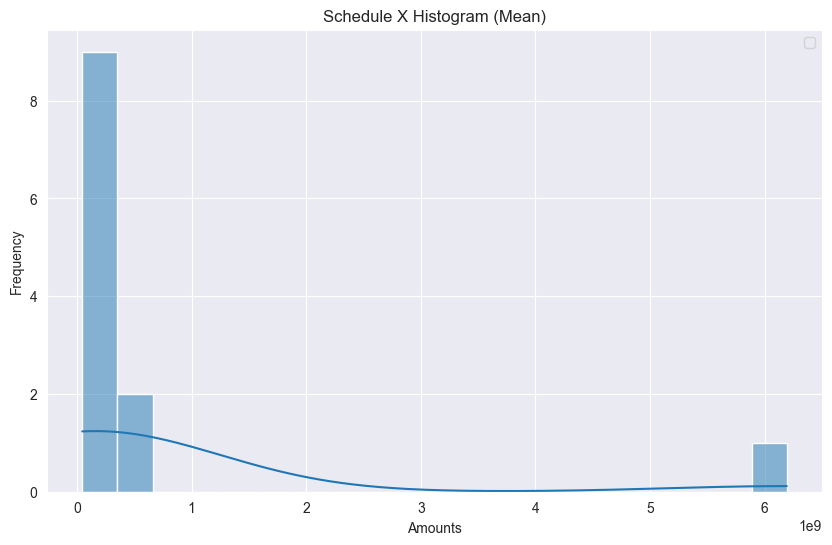

In [299]:
print( hdr )
print( 'Histogram' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.histplot( df_numeric.mean( ), bins=20, kde=True )
plt.title('Schedule X Histogram (Mean)')
plt.xlabel('Amounts')
plt.ylabel('Frequency')
plt.legend( loc='upper right' )
plt.show()



#### Probability Distributions
- A statistical function that describes all the possible values and likelihoods that a random variable can take within a given range.


------------------------------------------------------------------------------------------------------------------------

CY Probabilty Distribution Graph




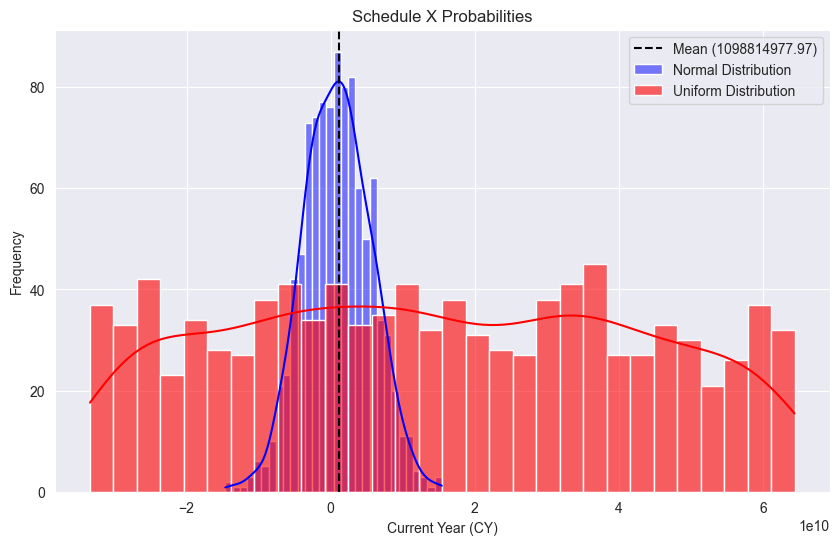

In [300]:
# Selecting CY data and removing zeros for statistical analysis
df_currentyear = df_numeric[ 'CY' ].replace( 0, np.nan ).dropna( )

# 2. Generating Normal Distribution
mu, sigma = np.mean( df_currentyear ), np.std( df_currentyear )
normal_dist = np.random.normal(mu, sigma, 1000 )

# 3. Generating Uniform Distribution
uniform_dist = np.random.uniform( df_currentyear.min( ), df_currentyear.max( ), 1000 )

print( hdr )
print( 'CY Probabilty Distribution Graph')
print( nwln )

# 4. Plotting the Distributions
plt.figure( figsize=( 10, 6 ) )
sns.histplot( normal_dist, bins=30, kde=True, color='blue', label='Normal Distribution')
sns.histplot( uniform_dist, bins=30, kde=True, color='red', label='Uniform Distribution', alpha=0.6)
plt.axvline( mu, color='black', linestyle='dashed', label=f'Mean ({mu:.2f})')
plt.legend( )
plt.title( 'Schedule X Probabilities' )
plt.xlabel( 'Current Year (CY)' )
plt.ylabel( 'Frequency' )
plt.show( )



------------------------------------------------------------------------------------------------------------------------

Probability Distributions




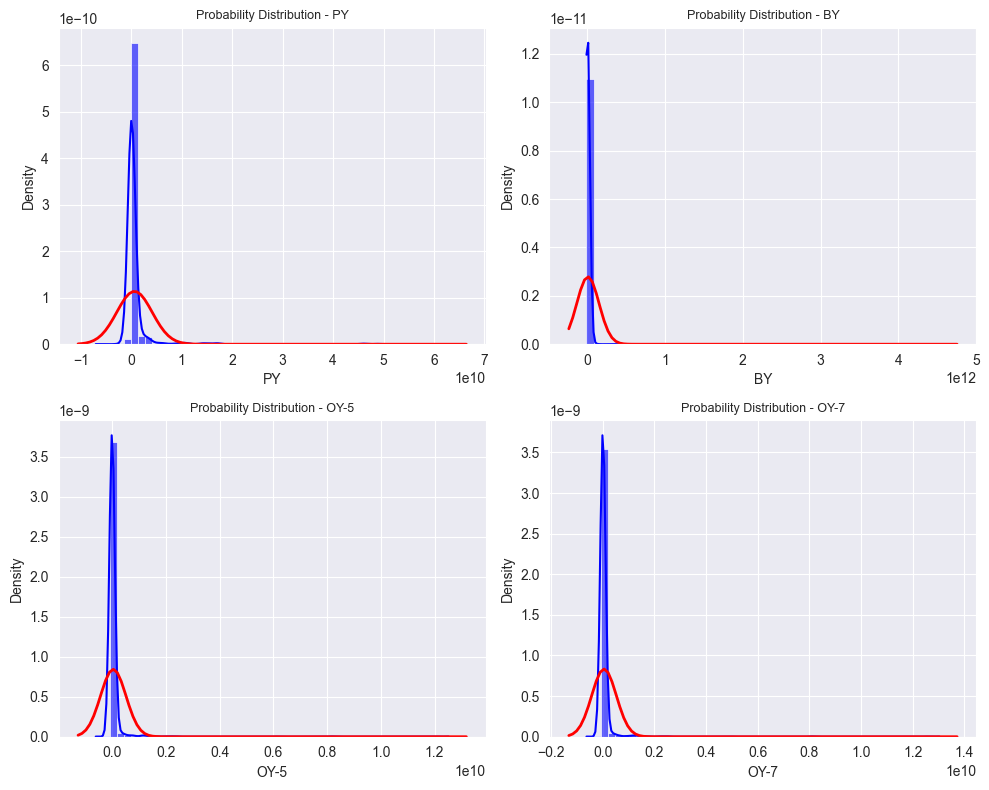

In [301]:
# Plot probability distributions for selected financial columns
fig, axes = plt.subplots( 2, 2, figsize=(10, 8) )

# Select columns to analyze
columns_to_analyze = [ 'PY', 'BY', 'OY-5', 'OY-7' ]

for ax, col in zip( axes.flatten( ), columns_to_analyze ):
	data = df_numeric[ col ].dropna( )
	mu, std = stats.norm.fit( data )
	sns.histplot( data, bins=50, kde=True, color='blue', alpha=0.6, ax=ax,
		stat = 'density' )
	xmin, xmax = ax.get_xlim( )
	x = np.linspace( xmin, xmax, 100 )
	p = stats.norm.pdf( x, mu, std )
	ax.plot( x, p, 'r', linewidth=2 )
	ax.set_title( f'Probability Distribution - {col}', fontsize=9 )

print( hdr )
print( 'Probability Distributions' )
print( nwln )

plt.tight_layout( )
plt.show( )

___

## 🔍 Inferrential Statistics


| Metric           | Description                                            | Use in Budget Analysis                                               |
|-------------------------|--------------------------------------------------------|----------------------------------------------------------------------|
| **Pearson Correlation** | Linear relationship between variables                  | E.g., Correlates reported values from PY to OY-9                     |
| **Spearman Correlation**| Monotonic (rank-based) relationship                    | More robust to non-linear trends in financial execution              |
| **t-test**              | Compare means between 2 groups                         | PY and BY execution rates                                            |
| **ANOVA**               | Compare means across multiple groups                   | Obligations across CY and BY                                         |
| **Chi-square Test**     | Categorical independence                               | Are Main Account Codes related to availability or a specific agency? |
| **Confidence Intervals**| Estimate range of a population mean                    | Upper and lower bound expected CY to OY-9 values                     |
| **Regression Coefficients (p-values)** | Test variable significance                             | Are Recoveries a significant predictor of UnobligatedBalance?        |
| **F-statistic (overall regression)**   | Test whole model fit                                   | Determines the combined influence of all predictors                  |
| **Z-score / Outlier Tests** | Deviation from standard mean                           | Identify abnormal balances or lapse rates                            |
| **Boxplots**            | Visual outlier detection                               | Discover obligation anomalies within agencies                        |




- Involves the use of a sample (1) to estimate some characteristic in a large population; and (2) to test a research hypothesis about a given population.
- To appropriately estimate a population characteristic, or parameter, a random and unbiased sample must be drawn from the population of interest

In [303]:
# Perform a One-Sample t-Test to check if CY significantly differs from zero
t_stat, p_value = stats.ttest_1samp( df_currentyear, 0 )

# Perform an ANOVA test across multiple fiscal years (PY to BY)
df_anova_test = df_numeric.loc[ :, 'PY':'BY' ]
anova_stat, anova_p = stats.f_oneway( *[ df_anova_test[ col ] for col in df_anova_test.columns ] )

# Display results in a DataFrame
df_hypothesis = pd.DataFrame({
    'Test': [ 't-Test', 'ANOVA' ],
    'Statistic':  [t_stat, anova_stat ],
    'p-Value': [ p_value, anova_p ]
}).round(4)

print( hdr )
print( 'ANOVA')
print( nwln )

df_summary = pd.DataFrame( df_hypothesis )
df_summary


------------------------------------------------------------------------------------------------------------------------

ANOVA




,Test,Statistic,p-Value
0,t-Test,8.6205,0.0000
1,ANOVA,3.6363,0.0264


#### Confidence Intervals
- 95% confidence level

In [305]:
# Confidence Intervals (95% confidence level)
confidence_level = 0.95
means = df_numeric.mean( )
std_errors = df_numeric.std( ) / np.sqrt( len( df_numeric ) )
confidence_intervals = {
		col: stats.t.interval( confidence_level, len( df_numeric[ col ] ) - 1, loc=means[ col ],
			scale = std_errors[ col ] )
		for col in df_numeric.columns
}

print( hdr )
print( 'Confidence Intervals (95% confidence level)' )
print( nwln )

df_confidence = pd.DataFrame( confidence_intervals, index = [ 'Lower', 'Upper' ] )
df_confidence.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Confidence Intervals (95% confidence level)




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
Lower,4.752737e+08,4.800866e+08,4.651687e+08,4.814521e+07,4.348990e+07,4.042793e+07,3.802086e+07,28253455.24,28431067.49,27700495.40,28092760.79,27927022.39
Upper,7.560521e+08,7.670684e+08,1.191930e+10,1.194231e+08,1.298918e+08,1.441079e+08,1.609050e+08,66161544.76,66408099.17,66026171.27,66885572.54,66932144.28



------------------------------------------------------------------------------------------------------------------------

Confidence Interval Boxplot




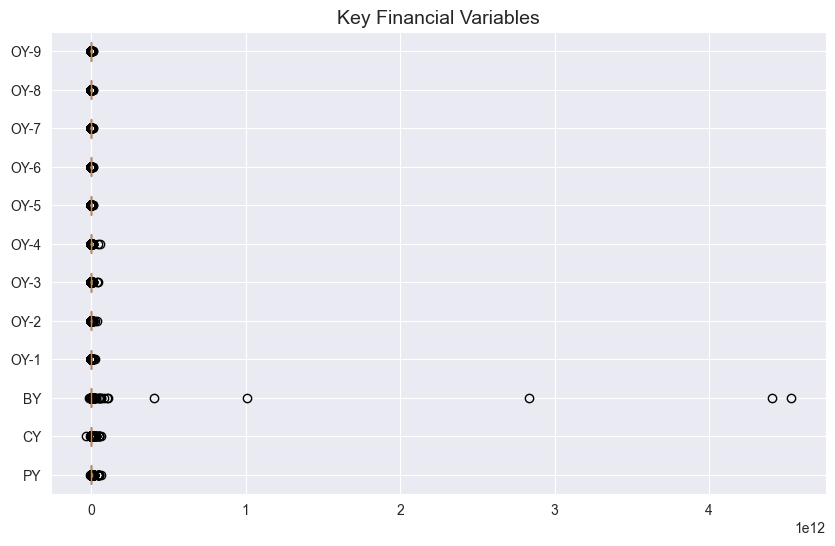

In [307]:
print( hdr )
print( 'Confidence Interval Boxplot' )
print( nwln )

# Boxplot for Confidence Intervals
plt.figure( figsize=( 10, 6 ) )
plt.boxplot( [ df_numeric[ col ] for col in numeric_columns ], vert=False, patch_artist = True )
plt.yticks( range( 1, len( numeric_columns ) + 1 ), numeric_columns )
plt.title( 'Key Financial Variables', fontsize=14 )
plt.show( )

#### Normality Testing
- Shapiro-Wilk

In [308]:
print( hdr )
print( 'Shapiro-Wilk Normality Testing' )
print( nwln )

# Normality Testing using the Shapiro-Wilk test
normality_results = { col: stats.shapiro( df_numeric[ col ].sample( 500, random_state = 1 ) ) for
					  col
					  in df_numeric.columns if len( df_numeric ) > 500 }
df_normality = pd.DataFrame( normality_results, index = [ 'Shaprio-Wilk Statistic', 'p-Value' ] )
df_normality.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Shapiro-Wilk Normality Testing




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
Shaprio-Wilk Statistic,0.19,0.19,0.02,0.07,0.06,0.05,0.04,0.14,0.14,0.14,0.13,0.13
p-Value,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### PY Metrics

In [309]:
# Compute statistical measures
mean_value = np.mean( df_schedx[ 'PY' ] )
median_value = np.median( df_schedx[ 'PY' ] )
mode_value = df_schedx[ 'PY' ].mode( ).iloc[ 0 ]
kurtosis_value = stats.kurtosis( df_schedx[ 'PY' ] )
skewness_value = stats.skew( df_schedx[ 'PY' ] )
std_dev_value = np.std( df_schedx[ 'PY' ] )

# Create a summary table
df_prioryear_stats = pd.DataFrame( {
		'Statistic': [ 'Mean', 'Median', 'Mode', 'Kurtosis', 'Skewness', 'Standard Deviation' ],
		'Value': [ mean_value, median_value, mode_value, kurtosis_value, skewness_value,
				   std_dev_value ]
} ).round( 2 )

print( hdr )
print( 'Prior Year - Statistics' )
print( nwln )

# Display the statistics summary
df_prioryear_stats.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Prior Year - Statistics




,Statistic,Value
0,Mean,6.156629e+08
1,Median,1.000000e+06
2,Mode,0.000000e+00
3,Kurtosis,1.447400e+02
4,Skewness,1.097000e+01
5,Standard Deviation,3.506563e+09


#### CY Metrics

In [30]:
# Compute statistical measures
mean_value = np.mean( df_schedx[ 'CY' ] )
median_value = np.median( df_schedx[ 'CY' ] )
mode_value = df_schedx[ 'CY' ].mode( ).iloc[ 0 ]
kurtosis_value = stats.kurtosis( df_schedx[ 'CY' ] )
skewness_value = stats.skew( df_schedx[ 'CY' ] )
std_dev_value = np.std( df_schedx[ 'CY' ] )

# Create a summary table
df_currentyear_stats = pd.DataFrame( {
		'Statistic': [ 'Mean', 'Median', 'Mode', 'Kurtosis', 'Skewness', 'Standard Deviation' ],
		'Value': [ mean_value, median_value, mode_value, kurtosis_value, skewness_value,
				   std_dev_value ]
} ).round( 2 )

print( hdr )
print( 'Current Year Statistics' )
print( nwln )
# Display the statistics summary
df_currentyear_stats.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Current Year Statistics




,Statistic,Value
0,Mean,6.235775e+08
1,Median,1.000000e+06
2,Mode,0.000000e+00
3,Kurtosis,1.234900e+02
4,Skewness,9.210000e+00
5,Standard Deviation,3.584035e+09


#### BY Metrics

In [31]:
# Compute statistical measures
mean_value = np.mean( df_schedx[ 'BY' ] )
median_value = np.median( df_schedx[ 'BY' ] )
mode_value = df_schedx[ 'BY' ].mode( ).iloc[ 0 ]  # Selecting first mode if multiple exist
kurtosis_value = stats.kurtosis( df_schedx[ 'BY' ] )
skewness_value = stats.skew( df_schedx[ 'BY' ] )
std_dev_value = np.std( df_schedx[ 'BY' ] )

# Create a summary table
df_budgetyear_stats = pd.DataFrame( {
		'Statistic': [ 'Mean', 'Median', 'Mode', 'Kurtosis', 'Skewness', 'Standard Deviation' ],
		'Value': [ mean_value, median_value, mode_value, kurtosis_value, skewness_value,
				   std_dev_value ]
} ).round( 2 )

print( hdr )
print( 'Budget Year Statistics' )
print( nwln )

# Display the statistics summary
df_budgetyear_stats.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Budget Year Statistics




,Statistic,Value
0,Mean,6.192235e+09
1,Median,1.000000e+06
2,Mode,0.000000e+00
3,Kurtosis,8.510400e+02
4,Skewness,2.867000e+01
5,Standard Deviation,1.430474e+11


#### t-Test

In [310]:
# Perform t-tests between high and low execution groups
df_schedx[ 'ExecutionRate' ] = df_schedx[ 'BY' ] / df_schedx[ 'OY-7' ]
df_schedx = df_schedx.replace( [ np.inf, -np.inf ], np.nan ).dropna( subset = [ 'ExecutionRate' ] )
threshold = df_schedx[ 'ExecutionRate' ].median( )
df_schedx[ 'HighExecution' ] = (df_schedx[ 'ExecutionRate' ] > threshold).astype( int )

# Update variables list based on correct column names
variables = numeric_columns

# Re-run the t-test loop
ttest_results = [ ]

for var in variables:
	group0 = df_schedx[ df_schedx[ 'HighExecution' ] == 0 ][ var ]
	group1 = df_schedx[ df_schedx[ 'HighExecution' ] == 1 ][ var ]
	t_stat, p_val = stats.ttest_ind( group0, group1, equal_var = False )
	ttest_results.append( {
			'Variable': var,
			'High-Execution': group0.mean( ).round( 2 ),
			'Low-Execution': group1.mean( ).round( 2 ),
			't-Statistic': t_stat.round( 2 ),
			'p-Value': p_val
	} )

df_ttest = pd.DataFrame( ttest_results )

print( hdr )
print( 't-Test Results' )
print( nwln )

df_ttest.round( 2 )


------------------------------------------------------------------------------------------------------------------------

t-Test Results




,Variable,High-Execution,Low-Execution,t-Statistic,p-Value
0,PY,1.250597e+08,6.344776e+07,1.65,0.10
1,CY,9.190547e+07,2.499701e+08,-1.99,0.05
2,BY,1.650547e+08,2.737065e+08,-1.12,0.26
3,OY-1,1.998209e+08,2.949751e+08,-0.86,0.39
4,OY-2,2.253234e+08,3.075622e+08,-0.69,0.49
5,OY-3,2.448806e+08,2.874328e+08,-0.37,0.71
6,OY-4,2.589801e+08,2.763632e+08,-0.15,0.88
7,OY-5,2.690398e+08,2.716119e+08,-0.02,0.98
8,OY-6,2.792886e+08,2.700547e+08,0.08,0.93
9,OY-7,2.897761e+08,2.697861e+08,0.18,0.86


#### Mann-Whitney

In [311]:
results = [ ]
correlation_vars = [ 'PY', 'CY', 'BY', 'OY-1', 'OY-7' ]

for col in correlation_vars:
	group0 = df_schedx[ df_schedx[ 'HighExecution' ] == 0 ][ col ]
	group1 = df_schedx[ df_schedx[ 'HighExecution' ] == 1 ][ col ]
	u_stat, u_p = stats.mannwhitneyu( group0, group1, alternative = 'two-sided' )
	results.append( {
			'Test': f'Mann-Whitney U: {col}',
			'Statistic': round( u_stat, 4 ),
			'p-Value': round( u_p, 4 )
	} )

print( hdr )
print( 'Mann-Whitney Results' )
print( nwln )

# Display result
df_mann_whitney = pd.DataFrame( results )
df_mann_whitney


------------------------------------------------------------------------------------------------------------------------

Mann-Whitney Results




,Test,Statistic,p-Value
0,Mann-Whitney U: PY,25915.5,0.0000
1,Mann-Whitney U: CY,14368.0,0.0000
2,Mann-Whitney U: BY,19845.5,0.7608
3,Mann-Whitney U: OY-1,21709.5,0.1952
4,Mann-Whitney U: OY-7,23893.5,0.0015


#### Chi-Squared

In [312]:

# Chi-square test on 'BY' if applicable
if 'BY' in df_numeric.columns and df_numeric[ 'BY' ].nunique( ) < 50:
	contingency_table = pd.crosstab( df_numeric[ 'BY' ], df_numeric[ 'PY' ] )
	chi2, chi2_p, _, _ = stats.chi2_contingency( contingency_table )
	results.append( {
			'Test': 'Chi-square: Availability vs Execution',
			'Statistic': round( chi2, 4 ),
			'p-Value': round( chi2_p, 4 )
	} )

print( hdr )
print( 'Chi-Square Results' )
print( nwln )

# Display result
df_chisquared = pd.DataFrame( results )
df_chisquared


------------------------------------------------------------------------------------------------------------------------

Chi-Square Results




,Test,Statistic,p-Value
0,Mann-Whitney U: PY,25915.5,0.0000
1,Mann-Whitney U: CY,14368.0,0.0000
2,Mann-Whitney U: BY,19845.5,0.7608
3,Mann-Whitney U: OY-1,21709.5,0.1952
4,Mann-Whitney U: OY-7,23893.5,0.0015


## 🛠️  Feature Engineering
___

#### Normalization
- Z-score Scaling
- A method of standardizing data by representing each value as the number of standard deviations it is from the mean.

In [313]:
normalizer = Normalizer( )
df_normalized = pd.DataFrame( normalizer.fit_transform( df_numeric ), columns=df_numeric.columns )

print( hdr )
print( 'Normalized Feature Values' )
print( nwln )

# Prepare values for normalized regression and classification
normalized_values = df_normalized.iloc[ :, 1: ]
normalized_target = df_normalized.iloc[ :, 0 ]
normalized_classifier = (normalized_target > normalized_target.median( )).astype( int )

df_normalized.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Normalized Feature Values




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
0,0.58,0.58,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.58,0.58,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.58,0.58,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.58,0.58,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.54,0.64,0.54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.58,0.58,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2396,0.58,0.58,0.58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2397,0.52,0.52,0.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2398,0.50,0.50,0.70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Standardization
- Max-Min Scaling
- Rescaling the range of features to scale the range in [0, 1] or [−1, 1]

In [314]:
standardizer = StandardScaler( )
df_standardized = pd.DataFrame( standardizer.fit_transform( df_numeric ), columns=df_numeric.columns )

print( hdr )
print( 'Standardized Feature Values' )
print( nwln )

# Prepare values for normalized regression and classification
standardized_values = df_standardized.iloc[ :, 1: ]
standardized_target = df_standardized.iloc[ :, 0 ]
standardized_classifier = (standardized_target > standardized_target.median( )).astype( int )

df_standardized.round( 4 )


------------------------------------------------------------------------------------------------------------------------

Standardized Feature Values




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
0,0.0814,0.0774,-0.0370,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
1,-0.1522,-0.1511,-0.0427,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2,-0.1673,-0.1659,-0.0431,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
3,-0.0763,-0.0769,-0.0409,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
4,2.8211,3.3159,0.0302,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-0.1753,-0.1737,-0.0433,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2396,-0.1753,-0.1737,-0.0433,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2397,-0.1699,-0.1684,-0.0431,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974
2398,-0.1704,-0.1690,-0.0431,-0.0941,-0.0803,-0.0713,-0.0648,-0.0997,-0.1,-0.0979,-0.098,-0.0974


#### Min-Max Scaling

In [316]:
# Min-Max Scaling
minmaxscaler = MinMaxScaler( )
df_minmax = pd.DataFrame( minmaxscaler.fit_transform( df_numeric ),
	columns = df_numeric.columns )

print( hdr )
print( 'Scaled (Min-Max) Feature Values' )
print( nwln )

# Prepare values for normalized regression and classification
minmax_values = df_minmax.iloc[ :, 1: ]
minmax_target = df_standardized.iloc[ :, 0 ]
minmax_classifier = (minmax_target > minmax_target.median( )).astype( int )

df_minmax.round( 4 )


------------------------------------------------------------------------------------------------------------------------

Scaled (Min-Max) Feature Values




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
0,0.1139,0.3506,0.0030,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
1,0.1022,0.3423,0.0028,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
2,0.1014,0.3417,0.0028,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
3,0.1060,0.3450,0.0028,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
4,0.2511,0.4692,0.0051,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0.1010,0.3415,0.0028,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
2396,0.1010,0.3415,0.0028,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
2397,0.1013,0.3416,0.0028,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466
2398,0.1013,0.3416,0.0028,0.0209,0.0158,0.0127,0.0109,0.0461,0.0462,0.0463,0.0465,0.0466


#### Log Transfomations

In [82]:
# Log Transformations - log1p to handle zero values
df_logtransform = df_numeric.copy( )
df_logtransform[ numeric_columns ] = np.log1p( df_standardized[ numeric_columns ].fillna( 0 ) )

print( hdr )
print( 'Log Transformed Data' )
print( nwln )

df_logtransform.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Log Transformed Data




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
0,0.08,0.07,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
1,-0.17,-0.16,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
2,-0.18,-0.18,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
3,-0.08,-0.08,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
4,1.34,1.46,0.03,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-0.19,-0.19,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
2396,-0.19,-0.19,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
2397,-0.19,-0.18,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1
2398,-0.19,-0.19,-0.04,-0.1,-0.08,-0.07,-0.07,-0.11,-0.11,-0.1,-0.1,-0.1


#### Dimensionality Reduction


------------------------------------------------------------------------------------------------------------------------

Dimensionality-Reduction 




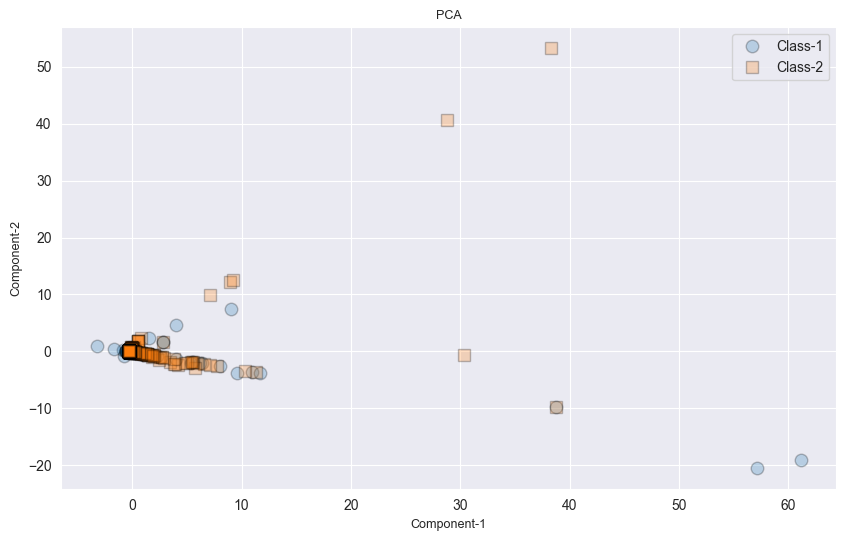

In [95]:
print( hdr )
print( 'Dimensionality-Reduction ' )
print( nwln )

reduction_methods = { 'PCA': PCA( n_components = 2 ) }

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( df_standardized )
		reduced_data[ name ] = X_red
		plt.figure( figsize = (10, 6) )
		mglearn.discrete_scatter( X_red[ :, 0 ], X_red[ :, 1 ], standardized_classifier,
			padding = .25, alpha = 0.25, markers = markers, s = 9 )
		plt.legend( [ 'Class-1', 'Class-2' ], loc = 'best' )
		plt.title( f'{name}', fontsize = 9 )
		plt.xlabel( 'Component-1', fontsize = 9 )
		plt.ylabel( 'Component-2', fontsize = 9 )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

#### Pricipal Component Analysis (PCA)
- A linear dimensionality reduction technique with applications in exploratory data analysis, visualization and data preprocessing.
- The data is linearly transformed onto a new coordinate system such that the directions capturing the largest variation in the data can be easily identified

In [96]:
pca = PCA( n_components=2 )
pca_result = pca.fit_transform( df_numeric )
df_pca = pd.DataFrame( pca_result, columns=[ 'Component-1', 'Component-2' ])


print( hdr )
print( 'Prinicipal Compnent Analysis' )
print( nwln )

df_pca.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Prinicipal Compnent Analysis




,Component-1,Component-2
0,-5.291121e+09,3.893587e+08
1,-6.110456e+09,-7.671927e+08
2,-6.163478e+09,-8.420367e+08
3,-5.844347e+09,-3.915607e+08
4,4.320274e+09,1.539096e+10
...,...,...
2395,-6.191489e+09,-8.815769e+08
2396,-6.191489e+09,-8.815769e+08
2397,-6.166481e+09,-8.547478e+08
2398,-6.167482e+09,-8.575724e+08


#### Incremental Component Analysis


------------------------------------------------------------------------------------------------------------------------

Incremental Principle Component Analysis




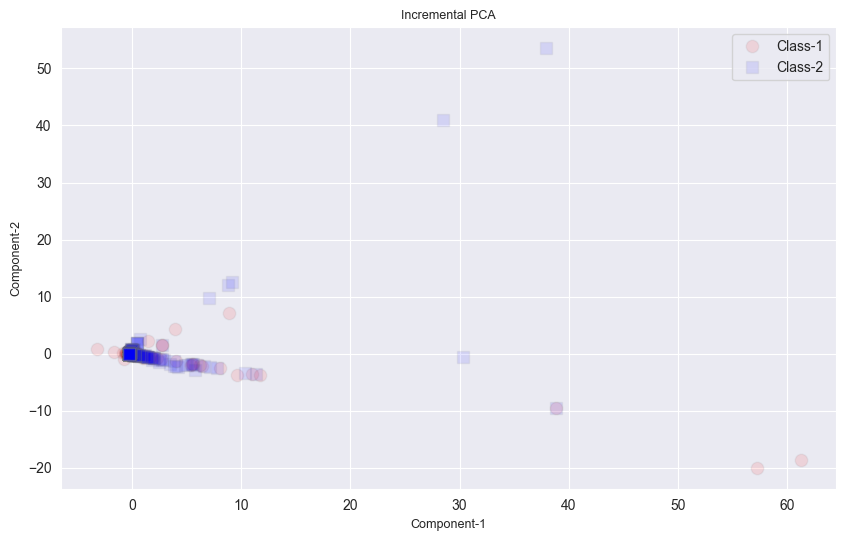

In [99]:
print( hdr )
print( 'Incremental Principle Component Analysis' )
print( nwln )

reduction_methods = {
		"Incremental PCA": IncrementalPCA( n_components = 2, batch_size = 20 ),
}

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( df_standardized )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize = (10, 6) )
		mglearn.discrete_scatter( X_red[ :, 0 ], X_red[ :, 1 ], standardized_classifier,
			padding = .25, c = colors, alpha = 0.1, markers = markers, s = 9 )
		plt.legend( [ 'Class-1', 'Class-2' ], loc = 'best' )
		plt.title( f'{name}', fontsize = 9 )
		plt.xlabel( 'Component-1', fontsize = 9 )
		plt.ylabel( 'Component-2', fontsize = 9 )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

#### Truncated Support Vectors


------------------------------------------------------------------------------------------------------------------------

Truncated Support Vector




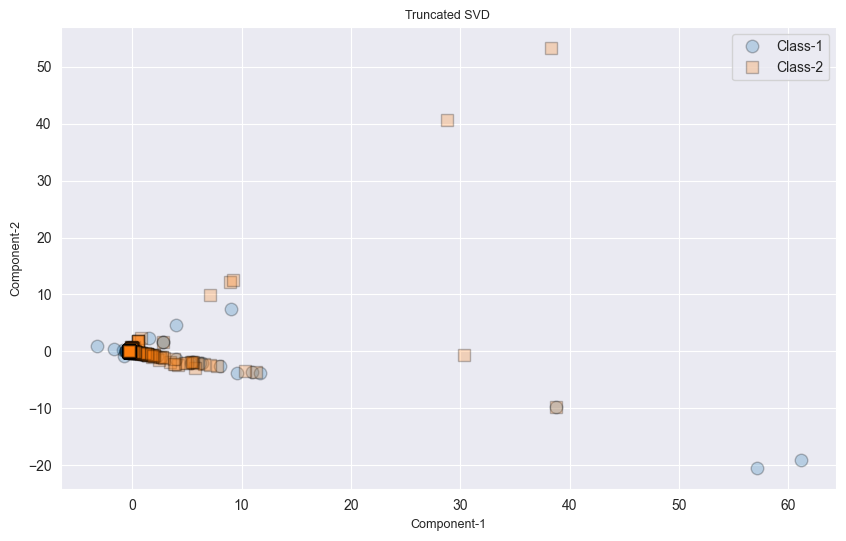

In [102]:
print( hdr )
print( 'Truncated Support Vector' )
print( nwln )

reduction_methods = {
		"Truncated SVD": TruncatedSVD( n_components = 2 ),
}

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( df_standardized )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize = ( 10, 6 ) )
		mglearn.discrete_scatter( X_red[ :, 0 ], X_red[ :, 1 ], standardized_classifier,
			padding = .25, alpha = 0.25, markers = markers, s = 9 )
		plt.legend( [ 'Class-1', 'Class-2' ], loc = 'best' )
		plt.title( f'{name} ', fontsize = 9 )
		plt.xlabel( 'Component-1', fontsize = 9 )
		plt.ylabel( 'Component-2', fontsize = 9 )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

#### Factor Analysis


------------------------------------------------------------------------------------------------------------------------

Factor Analysis




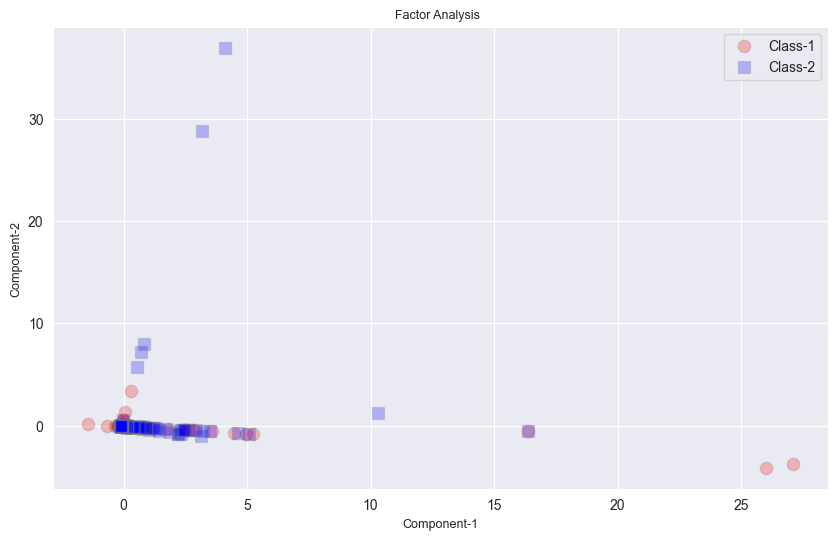

In [105]:
print( hdr )
print( 'Factor Analysis' )
print( nwln )

reduction_methods = {
		"Factor Analysis": FactorAnalysis( n_components=2 )
}

reduced_data = { }

for name, reducer in reduction_methods.items( ):
	try:
		X_red = reducer.fit_transform( df_standardized )
		reduced_data[ name ] = X_red

		# Plot each result
		plt.figure( figsize = (10, 6) )
		mglearn.discrete_scatter( X_red[ :, 0 ], X_red[ :, 1 ], standardized_classifier,
			padding = .25, c = colors, alpha = 0.25, markers = markers, s = 9 )
		plt.legend( [ 'Class-1', 'Class-2' ], loc = 'best' )
		plt.title( f'{name}  ', fontsize = 9 )
		plt.xlabel( 'Component-1', fontsize = 9 )
		plt.ylabel( 'Component-2', fontsize = 9 )
		plt.grid( True )
		plt.show( )

	except Exception as e:
		print( f"{name} failed: {e}" )

#### Polynomial-Interaction Features

In [97]:
# Polynomial & Interaction Features
poly = PolynomialFeatures( degree=2, interaction_only=True, include_bias=False )
poly_features = poly.fit_transform( df_standardized[ numeric_columns ].fillna( 0 ) )
df_polynomial = pd.DataFrame( poly_features, index=df_standardized.index  )

print( hdr )
print( 'Polynomial Features' )
print( nwln )

df_polynomial.round( 2 )


------------------------------------------------------------------------------------------------------------------------

Polynomial Features




,0,1,2,3,4,5,6,7,8,9,...,68,69,70,71,72,73,74,75,76,77
0,0.08,0.08,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,-0.15,-0.15,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,-0.17,-0.17,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
3,-0.08,-0.08,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
4,2.82,3.32,0.03,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,-0.18,-0.17,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2396,-0.18,-0.17,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2397,-0.17,-0.17,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2398,-0.17,-0.17,-0.04,-0.09,-0.08,-0.07,-0.06,-0.1,-0.1,-0.1,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


#### K-Means Clustering
- A machinel learning method for grouping data into clusters based on similarity

In [62]:
kmeans = KMeans( n_clusters=2, random_state=42, n_init=10 )
kmeans_clusters = kmeans.fit_predict( df_standardized )

kmeans_clusters

array([0, 0, 0, ..., 0, 0, 0])

#### PCA + K-Means
- Combines and applies K-Means Clustering with Pricipal Component Analysis


------------------------------------------------------------------------------------------------------------------------

PCA & k-Means




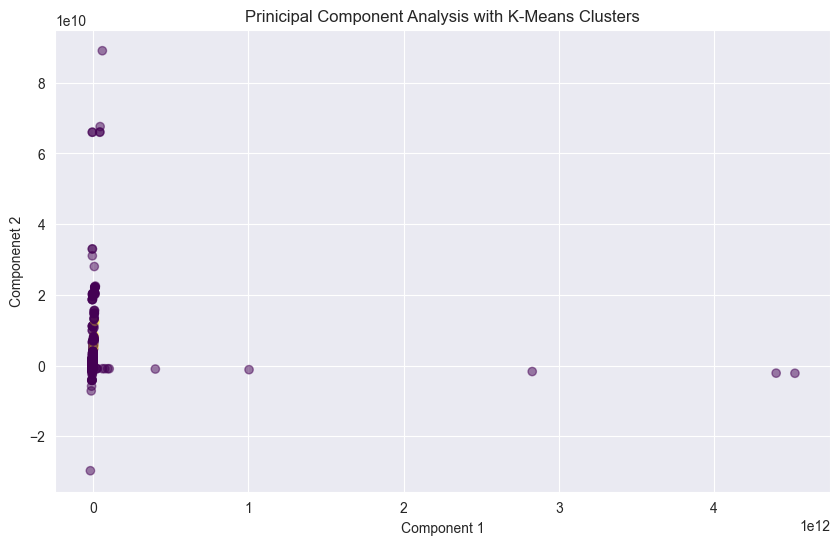


------------------------------------------------------------------------------------------------------------------------

Comparison of Primary Components




,Component-1,Component-2
0,-5.291121e+09,3.893587e+08
1,-6.110456e+09,-7.671927e+08
2,-6.163478e+09,-8.420367e+08
3,-5.844347e+09,-3.915607e+08
4,4.320274e+09,1.539096e+10
...,...,...
2395,-6.191489e+09,-8.815769e+08
2396,-6.191489e+09,-8.815769e+08
2397,-6.166481e+09,-8.547478e+08
2398,-6.167482e+09,-8.575724e+08


In [63]:
print( hdr )
print( 'PCA & k-Means' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.scatter( df_pca[ 'Component-1' ], df_pca[ 'Component-2' ],  c=kmeans_clusters, cmap='viridis', alpha=0.5 )
plt.title( 'Prinicipal Component Analysis with K-Means Clusters' )
plt.xlabel( 'Component 1' )
plt.ylabel( 'Componenet 2' )
plt.show( )

print( hdr )
print( 'Comparison of Primary Components' )
print( nwln )

df_pca

#### Label Encoding

In [69]:
# Label Encoding: Encode a column with nominal categories (e.g., AgencyName)
df_label = df_schedx[ [ 'MainAccount' ] ].dropna( )
le = LabelEncoder( )
main_encoded = le.fit_transform( df_label[ [ 'MainAccount' ] ] )

df_label = df_schedx[ [ 'LineName' ] ].dropna( )
le = LabelEncoder( )
line_encoded = le.fit_transform( df_label[ [ 'LineName' ] ] )

print( hdr )
print( 'Label Encoding' )
print( nwln )

print( main_encoded )


------------------------------------------------------------------------------------------------------------------------

Label Encoding


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8
  8  8  8  9  9 10 10 11 11 11 11 11 11 11 11 12 12 12 12

#### KNN Imputation

In [70]:
# KNN Imputation: Use multiple numerical columns
df_knn = df_dataset[ numeric_columns ].copy( )
knn_imputer = KNNImputer( n_neighbors = 3 )
knn_imputed_df = pd.DataFrame( knn_imputer.fit_transform( df_knn ), columns = df_knn.columns )

print( hdr )
print( 'Nearest Neighbor Imputer' )
print( nwln )

df_knn


------------------------------------------------------------------------------------------------------------------------

Nearest Neighbor Imputer




,PY,CY,BY,OY-1,OY-2,OY-3,OY-4,OY-5,OY-6,OY-7,OY-8,OY-9
0,901000000,901000000,901000000,0,0,0,0,0,0,0,0,0
1,82000000,82000000,82000000,0,0,0,0,0,0,0,0,0
2,29000000,29000000,29000000,0,0,0,0,0,0,0,0,0
3,348000000,348000000,348000000,0,0,0,0,0,0,0,0,0
4,10508000000,12508000000,10508000000,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2395,1000000,1000000,1000000,0,0,0,0,0,0,0,0,0
2396,1000000,1000000,1000000,0,0,0,0,0,0,0,0,0
2397,20000000,20000000,26000000,0,0,0,0,0,0,0,0,0
2398,18000000,18000000,25000000,0,0,0,0,0,0,0,0,0


## Anomaly Detection

#### 📈 Isloation Forest

In [71]:
print( hdr )
print( 'Anomaly Detection' )
print( nwln )

anomaly_models = {
		"OneClassSVM": OneClassSVM( nu = 0.05, kernel = "rbf", gamma = "scale" ),
		"IsolationForest": IsolationForest( contamination = 0.05, random_state = 42 )
}

for name, model in anomaly_models.items( ):
	model.fit( standardized_values )
	preds = model.predict( standardized_values )  # -1 = outlier, 1 = inlier
	anomaly_models[ name ] = {
			'Outliers': int( ( preds == -1 ).sum( ) ),
			'Inliers': int( ( preds == 1 ).sum( ) ),
			'Sample Labels': preds[ :10 ].tolist( )
	}

outliers = int( ( preds == -1).sum( ) )
inliers = int( (preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'Isolation-Forest:' )
print( '----------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )


------------------------------------------------------------------------------------------------------------------------

Anomaly Detection


Isolation-Forest:
----------------
Outliers - 120
Inliers - 2280
Labels - 10


#### 📋 One-Class, Support Vector Machine

In [72]:
print( hdr )
print( 'Anomaly Detection' )
print( nwln )

anomaly_models = {
		'OneClassSVM': OneClassSVM( nu = 0.05, kernel = 'rbf', gamma = 'scale' )
}

for name, model in anomaly_models.items( ):
	model.fit( standardized_values )
	preds = model.predict( standardized_values )  # -1 = outlier, 1 = inlier
	anomaly_models[ name ] = {
			'Outliers': int( (preds == -1).sum( ) ),
			'Inliers': int( (preds == 1).sum( ) ),
			'Sample Labels': preds[ :10 ].tolist( )
	}

outliers = int( (preds == -1).sum( ) )
inliers = int( (preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'One-Class, Support Vector Machine:' )
print( '----------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )


------------------------------------------------------------------------------------------------------------------------

Anomaly Detection


One-Class, Support Vector Machine:
----------------
Outliers - 119
Inliers - 2281
Labels - 10


#### 🎯 Local Outlier Factor

In [73]:
print( hdr )
print( 'Anomaly Detection' )
print( nwln )

anomaly_models = {
		'LocalOutlierFactor': LocalOutlierFactor( n_neighbors = 20, contamination = 0.05,
			novelty = True )
}

anomaly_results = { }
for name, model in anomaly_models.items( ):
	try:
		model.fit( standardized_values )
		preds = model.predict( standardized_values )  # -1 = outlier, 1 = inlier
		anomaly_results[ name ] = {
				'Outliers': int( ( preds == -1 ).sum( ) ),
				'Inliers': int( ( preds == 1 ).sum( ) ),
				'Sample Labels': preds[ :10 ].tolist( )
		}
	except Exception as e:
		anomaly_results[ name ] = { 'Error': str( e ) }

outliers = int( (preds == -1).sum( ) )
inliers = int( (preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'Local Outlier Factor:' )
print( '----------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )


------------------------------------------------------------------------------------------------------------------------

Anomaly Detection


Local Outlier Factor:
----------------
Outliers - 116
Inliers - 2284
Labels - 10


#### ✨ Elliptic Envelope

In [74]:
print( hdr )
print( 'Anomaly Detection' )
print( nwln )

anomaly_models = {
		'EllipticEnvelope': EllipticEnvelope( contamination = 0.05, random_state = 42 )
}

anomaly_results = { }
for name, model in anomaly_models.items( ):
	try:
		model.fit( standardized_values )
		preds = model.predict( standardized_values )  # -1 = outlier, 1 = inlier
		anomaly_results[ name ] = {
				'Outliers': int( (preds == -1).sum( ) ),
				'Inliers': int( (preds == 1).sum( ) ),
				'Sample Labels': preds[ :10 ].tolist( )
		}
	except Exception as e:
		anomaly_results[ name ] = { "Error": str( e ) }

outliers = int( (preds == -1).sum( ) )
inliers = int( (preds == 1).sum( ) )
labels = preds[ :10 ].tolist( )

print( 'Elliptic Envelope:' )
print( '----------------' )
print( f'Outliers - {outliers}' )
print( f'Inliers - {inliers}' )
print( f'Labels - {len( labels )}' )


------------------------------------------------------------------------------------------------------------------------

Anomaly Detection


Elliptic Envelope:
----------------
Outliers - 120
Inliers - 2280
Labels - 10


### Observations:

##### PCA Results:
- The first two principal components explain the majority of the variance in budget outlays, helping to simplify complex data.

##### K-means Clustering:
- The data naturally clusters into three groups, potentially reflecting different spending patterns across agencies or time periods.


## 📊  Correlation Analysis
___

#### Pearson Correlation
- A correlation that measures the linear relationship between two sets of data


------------------------------------------------------------------------------------------------------------------------

Pearson Correlation Heatmap




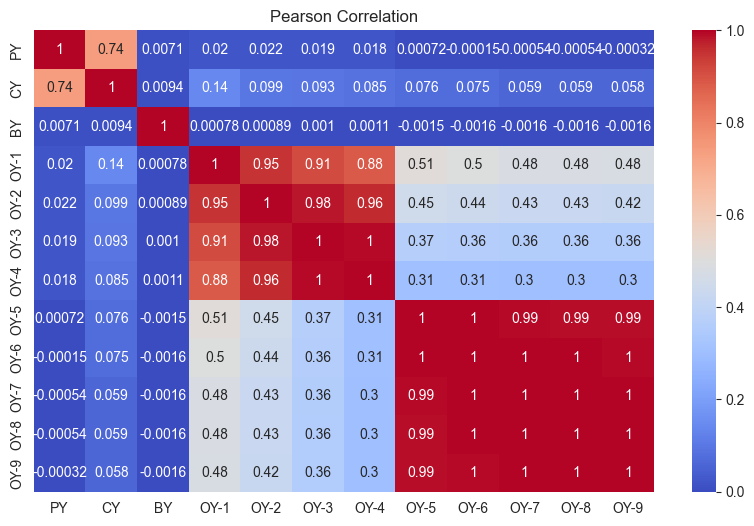

In [75]:
pearson_corr = df_numeric.corr( method= 'pearson' )
print( hdr )
print( 'Pearson Correlation Heatmap' )
print( nwln )

# Plot heatmaps of different correlations
plt.figure( figsize=( 10, 6 ) )
sns.heatmap( pearson_corr, cmap="coolwarm", annot=True )
plt.title('Pearson Correlation')
plt.show( )

#### Spearman Correlation
-  A statistical technique used to determine if two variables are related.
- It's used when the relationship between the variables is not linear, or when the data is not normally distributed.

In [76]:
spearman_corr = df_numeric.corr( method= 'spearman' )


------------------------------------------------------------------------------------------------------------------------

Spearman Correlation




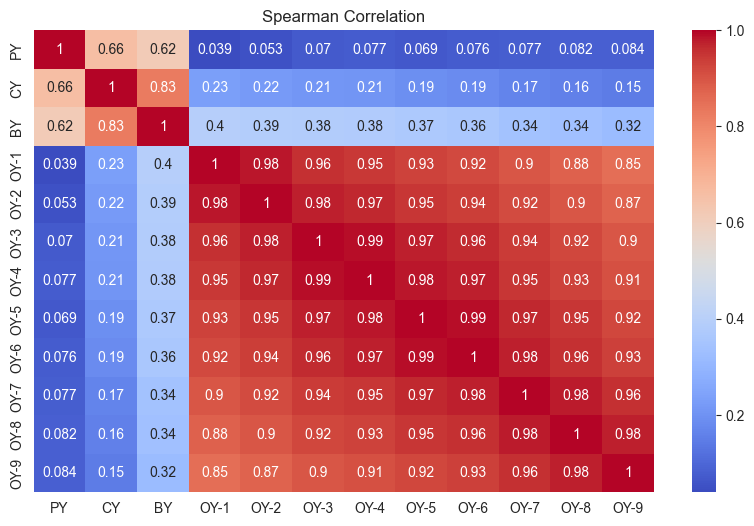

In [121]:
print( hdr )
print( 'Spearman Correlation')
print( nwln )

plt.figure( figsize=( 10, 6 ) )
sns.heatmap( spearman_corr, cmap='coolwarm', annot=True )
plt.title( 'Spearman Correlation' )
plt.show( )


#### Kendall Correlation
- A non-parametric statistical test that measures the association between two variables.
- It's used to determine if there is a correlation between two sets of ranks



In [77]:
kendall_corr = df_numeric.corr( method= 'kendall' )


------------------------------------------------------------------------------------------------------------------------

XIII. Tau Correlation




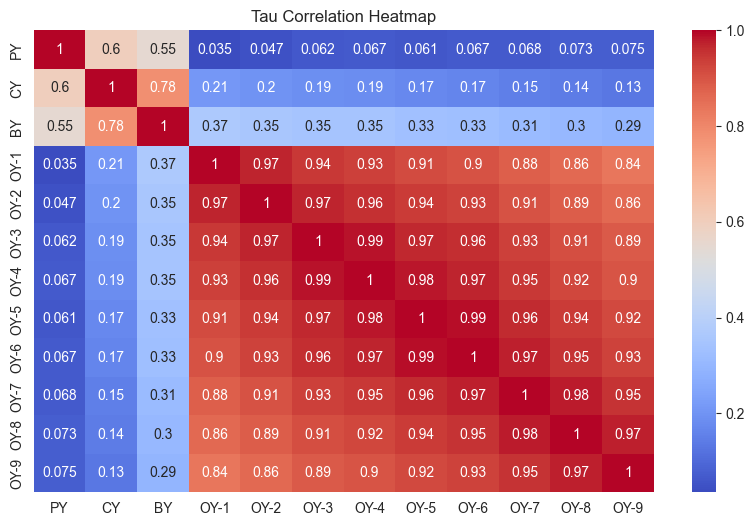

In [123]:
print( hdr )
print( 'XIII. Tau Correlation')
print( nwln )

plt.figure( figsize=( 10, 6 ))
sns.heatmap( kendall_corr, cmap="coolwarm", annot=True )
plt.title( 'Tau Correlation Heatmap' )
plt.show()


In [124]:
# Prepare dataframe for correlation comparison
df_correlation = pd.DataFrame({ 'Pearson Correlation': pearson_corr.iloc[:-1, -1].values,
    "Spearman Correlation": spearman_corr.iloc[:-1, -1].values,
    "Kendall Correlation": kendall_corr.iloc[:-1, -1].values,
})

# Display correlation comparison results
print( hdr )
print( 'XIV.  Table of Correlations')
print( nwln )
df_correlation


------------------------------------------------------------------------------------------------------------------------

XIV.  Table of Correlations




,Pearson Correlation,Spearman Correlation,Kendall Correlation
0,-0.000324,0.084285,0.074704
1,0.058041,0.145578,0.131781
2,-0.001557,0.319683,0.291364
3,0.478117,0.852930,0.837785
4,0.424597,0.873899,0.862148
5,0.356553,0.898193,0.889753
6,0.301387,0.907829,0.900852
7,0.989528,0.924797,0.918717
8,0.995055,0.933602,0.928508
9,0.998391,0.956119,0.952796


## 📈  Regression Analysis
- Methods to determine the strength and character of the relationship between a dependent variable and one or more independent variables
___

In [364]:
# Define future target years: Current Year and Budget Year
target_years = [ 'PY', 'CY', 'BY', 'OY-1' ]

# Extend dataset for forecasting
df_numeric = df_numeric.copy( )

# Use all Out Years as predictors
X_numeric = df_numeric.iloc[ :, :-4 ]

# Predict Outyear 1
y_numeric = df_numeric.iloc[ :, -4: ]

# Standardize features
scaler = StandardScaler()
X_standardized = scaler.fit_transform( X_numeric )

# Initialize regression models
regression_models = {
    'Linear Regression': LinearRegression( ),
    'Ridge Regression': Ridge( alpha=10.0, max_iter=10000 ),
    'Lasso Regression': Lasso( alpha=10.0, max_iter=10000 ),
    'ElasticNet Regression': ElasticNet( alpha=0.1, l1_ratio=0.5 ),
    'Bayesian Ridge Regression': BayesianRidge( max_iter=10000 ),
    'Random Forest Regression': RandomForestRegressor( n_estimators=50, random_state=42 ),
    'Gradient Boosting Regression': GradientBoostingRegressor( n_estimators=50, random_state=42 ),
    'Polynomial Regression (Degree=2)': LinearRegression( ),
}

# Polynomial transformation for polynomial regression
poly = PolynomialFeatures( degree=2 )
X_polynomial = poly.fit_transform( X_standardized )

# Fit and evaluate models for the outyears
regression_scores = { year: {} for year in target_years }

# Select target year
for year_idx, year in enumerate( target_years ):
    y_future = y_numeric.iloc[ :, year_idx ]

    for name, model in regression_models.items( ):
        if "Polynomial" in name:
            model.fit( X_polynomial, y_future )
            score_future = model.score( X_polynomial, y_future )
        else:
            model.fit( X_standardized, y_future )
            score_future = model.score( X_standardized, y_future )
        regression_scores[ year ][ name ] = round( score_future, 2 )

# Create ranked results for each year
df_results = {}
for year in target_years:
    ranked_models_future = sorted( regression_scores[ year ].items( ), key=lambda xX: xX[ 1 ], reverse=True )
    df_results[ year ] = pd.DataFrame( ranked_models_future, columns=[ "Regression Model", f"R² Score ({year})" ] )

# Prepare data for visualization
forecast_years = [ 'PY','CY','BY', 'OY-1' ]
model_names = list( regression_models.keys( ) )

print(hdr)
print('Prior Year')
print( nwln )
df_results[ 'PY' ]


------------------------------------------------------------------------------------------------------------------------

Prior Year




,Regression Model,R² Score (PY)
0,Linear Regression,1.00
1,Ridge Regression,1.00
2,Lasso Regression,1.00
3,Gradient Boosting Regression,1.00
4,Polynomial Regression (Degree=2),1.00
5,ElasticNet Regression,0.99
6,Random Forest Regression,0.99
7,Bayesian Ridge Regression,0.00


In [162]:
print(hdr)
print('Outyear 1')
print( nwln )

df_results[ 'OY-1' ]


------------------------------------------------------------------------------------------------------------------------

Outyear 1




,Regression Model,R² Score (OY-1)
0,Gradient Boosting Regression,1.00
1,Polynomial Regression (Degree=2),1.00
2,Linear Regression,0.99
3,Ridge Regression,0.99
4,Lasso Regression,0.99
5,Random Forest Regression,0.99
6,ElasticNet Regression,0.98
7,Bayesian Ridge Regression,0.00


In [109]:
print(hdr)
print('Current Year')
print( nwln )

df_results[ "CY" ]


------------------------------------------------------------------------------------------------------------------------

Current Year




,Regression Model,R² Score (CY)
0,Linear Regression,1.00
1,Ridge Regression,1.00
2,Lasso Regression,1.00
3,Gradient Boosting Regression,1.00
4,Polynomial Regression (Degree=2),1.00
5,ElasticNet Regression,0.99
6,Random Forest Regression,0.99
7,Bayesian Ridge Regression,0.00


In [163]:
print(hdr)
print('Budget Year')
print( nwln )

df_results[ "BY" ]


------------------------------------------------------------------------------------------------------------------------

Budget Year




,Regression Model,R² Score (BY)
0,Gradient Boosting Regression,1.00
1,Polynomial Regression (Degree=2),1.00
2,Linear Regression,0.99
3,Ridge Regression,0.99
4,Lasso Regression,0.99
5,ElasticNet Regression,0.99
6,Random Forest Regression,0.99
7,Bayesian Ridge Regression,0.00


## 🎯 Logistic Regression


------------------------------------------------------------------------------------------------------------------------

Logistic Regression
Training Score / Testing Score




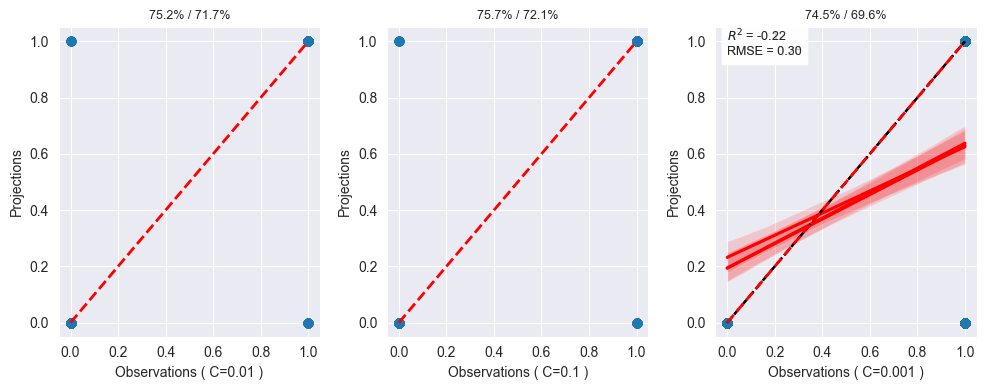

In [334]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_normalized.iloc[ :, 1: ]
target = df_normalized.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
logit_data = scaler.fit_transform( values )

# Split values
X_training, X_testing, y_training, y_testing = train_test_split( logit_data, classifier, test_size=0.2,
	random_state=42 )

# Prepare figure for 3 subplots
fig, axes = plt.subplots( 1, 3, figsize = (10, 4) )
Cs = [ .01, 0.1, .001 ]
print( hdr )
print( 'Logistic Regression' )
print( 'Training Score / Testing Score' )
print( nwln )

# Train and plot for each alpha
for i, c in enumerate( Cs ):
	# Fit & Predict
	logit = LogisticRegression( C = c )
	logit.fit( X_training, y_training )
	y_pred_logit = logit.predict( X_testing )
	r2 = r2_score( y_testing, y_pred_logit )
	training_score = f'{logit.score( X_training, y_training ):.1%}'
	testing_score = f'{logit.score( X_testing, y_testing ):.1%}'
	rmse = mean_squared_error( y_testing, y_pred_logit )
	if rmse > 100000000:
		rmse = 0.0
	sns.regplot( x = y_testing, y = y_pred_logit, scatter_kws = { 'alpha': 0.6 },
		line_kws = { 'color': 'red' } )
	plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
		label = 'Perfect Prediction' )
	plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
		s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
		fontsize = 9, bbox = dict( facecolor = 'white', alpha = 0.7 ) )

	# Plot predictions
	axes[ i ].scatter( y_testing, y_pred_logit, alpha = 0.6 )
	axes[ i ].plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ],
		'r--', lw = 2 )
	axes[ i ].set_title( f'{training_score} / {testing_score}', fontsize = 9 )
	axes[ i ].set_xlabel( f'Observations ( C={c} )' )
	axes[ i ].set_ylabel( 'Projections' )
	axes[ i ].grid( True )

plt.tight_layout( )
plt.show( )

## 🌳 Decision Tree Regression:
- This plot displays the predictions of a decision tree regression model trained on federal account-level financial data using TotalResources as the target.
- The tree partitions feature space into axis-aligned regions to minimize error in predicting continuous values.
- The vertical scatter seen in the plot reflects the model's nonlinear, piecewise-constant approximation behavior.
- It's interpretable and fast but may overfit if not pruned or tuned.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 100.0%
Testing  Score:  100.0%
Leaves: 367
Depth: 17




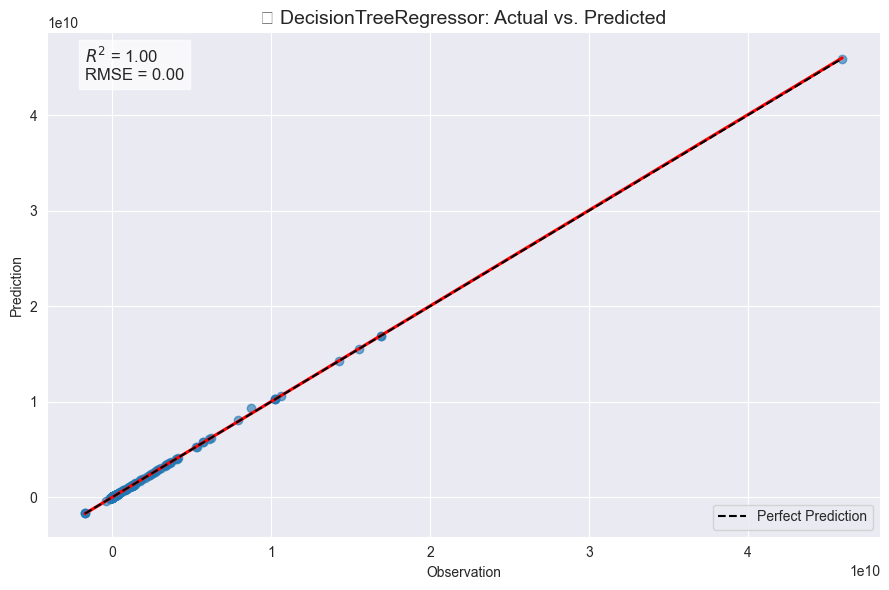

In [335]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.values
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_training, X_testing, y_training, y_testing = train_test_split( df_numeric.values, target,
	random_state = 42 )

# Regression
dt_reg = DecisionTreeRegressor( random_state = 42 )
dt_reg.fit( X_training, y_training )
y_pred_reg = dt_reg.predict( X_testing )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {dt_reg.score( X_training, y_training ):.1%}'
testing_score = f'Testing  Score:  {dt_reg.score( X_testing, y_testing ):.1%}'
leaves = f'Leaves: {dt_reg.get_n_leaves()}'
depth = f'Depth: {dt_reg.get_depth()}'
print( training_score )
print( testing_score )
print( leaves )
print( depth )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_reg )
rmse = mean_squared_error( y_testing, y_pred_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = (9, 6) )
sns.regplot( x = y_testing, y = y_pred_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Observation' )
plt.ylabel( 'Prediction' )
plt.title( '🌳 DecisionTreeRegressor: Actual vs. Predicted', fontsize = 14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

##  🌳 Decision Tree Classification
- This confusion matrix summarizes the performance of a classification tree tasked with predicting whether Outlays are above or below the median.
- It recursively splits the feature space based on information gain (Gini impurity).
- The model performs discrete binary classification and provides easily interpretable decision rules.
- Misclassifications may arise from noise or overfitting, especially without regularization.

Model Performance


Training Score: 100.00%
Testing Score:  100.00%
Leaves: 2
Depth: 1




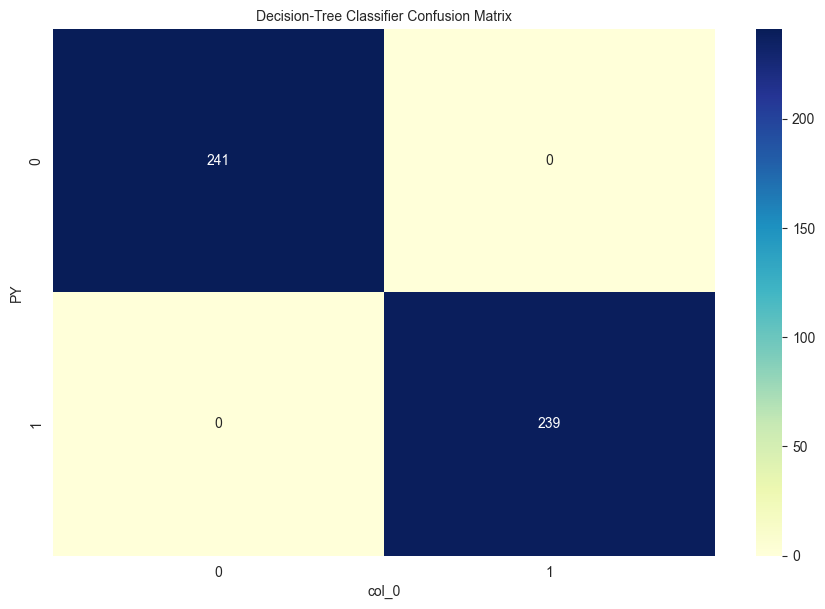

In [165]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric columns for modeling." )

# Prepare values for regression and classification
values = df_numeric.values
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split( df_numeric.values, classifier,
	test_size = .2, random_state = 42 )

# Train, Fit, & Predict
dt_cls = DecisionTreeClassifier( random_state = 42 )
dt_cls.fit( X_train_cls, y_train_cls )
y_pred_dt_cls = dt_cls.predict( X_test_cls )

# Score Model
training_score = f'Training Score: {dt_cls.score( X_train_cls, y_train_cls ):.2%}'
testing_score = f'Testing Score:  {dt_cls.score( X_test_cls, y_test_cls ):.2%}'
leaves = f'Leaves: {dt_cls.get_n_leaves( )}'
depth = f'Depth: {dt_cls.get_depth( )}'

# Score Model

print( 'Model Performance' )
print( nwln )
print( training_score )
print( testing_score )
print( leaves )
print( depth )
print( nwln )

plt.figure( figsize = (9, 6) )
sns.heatmap( pd.crosstab( y_test_cls, y_pred_dt_cls ), annot = True, fmt = 'd', cmap = 'YlGnBu' )
plt.tight_layout( )
plt.title( 'Decision-Tree Classifier Confusion Matrix', fontsize = 10 )
plt.grid( False )
plt.show( )

## 🌳 Decision Tree Learning-Curve
- Plots model performance vs. training set size.

###### Use:
- Diagnose underfitting/overfitting
- Understand model generalization

###### Results:
- Model accuracy vs. training set size
- Helps diagnose bias vs. variance

###### Inference:
- If training and validation scores converge at low accuracy → underfitting
- If wide gap → overfitting
- Plateau at high accuracy → enough data for generalization

###### Impact:
- Confirms whether current budget dataset size (e.g., number of accounts or agencies) is adequate to model execution behavior.
- Can reveal if more fiscal years, program types, or fund categories are needed.


------------------------------------------------------------------------------------------------------------------------

Learning Curve Accuracy




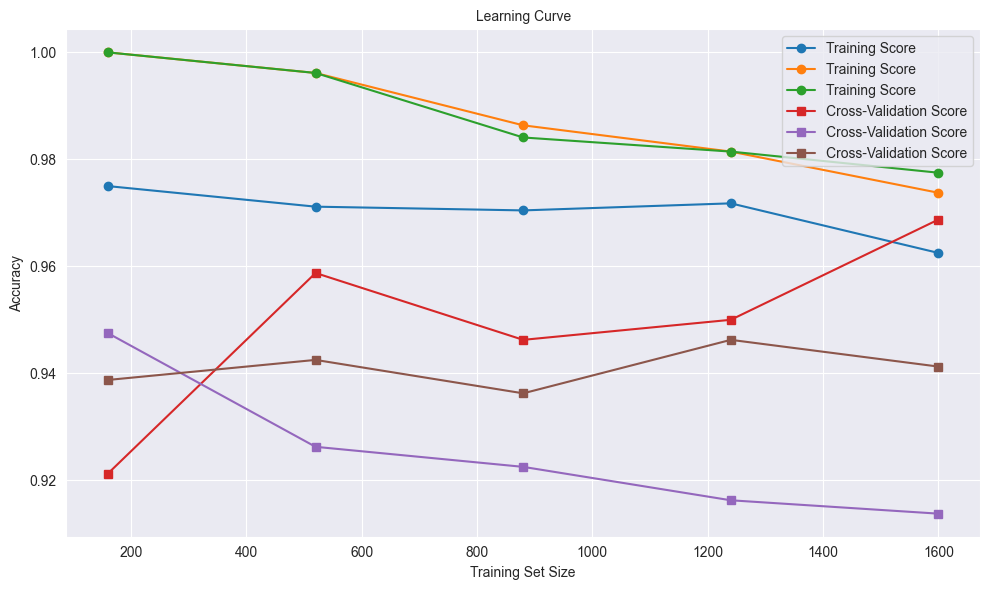

In [172]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( dt_cls, df_normalized.values, classifier, cv = 3,
	scoring = 'accuracy' )
print( hdr )
print( 'Learning Curve Accuracy')
print( nwln )

plt.figure( figsize = ( 10, 6 ) )
plt.plot( train_sizes, train_scores, label = 'Training Score', marker = 'o' )
plt.plot( train_sizes, test_scores, label = 'Cross-Validation Score', marker = 's' )
plt.title( 'Learning Curve', fontsize = 10 )
plt.xlabel( 'Training Set Size', fontsize = 10 )
plt.ylabel( 'Accuracy' )
plt.legend( loc='best' )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 🌳 Decision Tree Precision-Recall
- Plots Precision vs. Recall — especially useful for imbalanced classes.

###### Use:
- Understand how precision and recall trade off
- Choose optimal threshold

###### Results:
- Trade-off between Precision (purity of High Execution predictions) and Recall (completeness of High Execution predictions)

###### Inference:
- When recall is high but precision is low → the model finds most efficient accounts, but also mislabels many inefficients.
- A "bump" in the curve can suggest score thresholds that yield better balance.

###### Impact:
- If precision drops sharply after a threshold, agencies may want to set alert thresholds at higher confidence levels to reduce false flags.

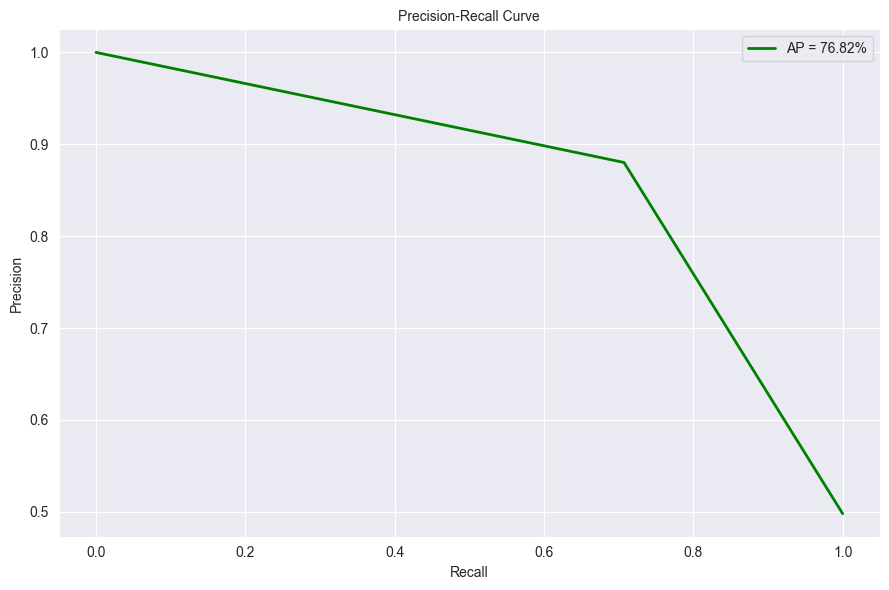

In [126]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve( y_test_cls, y_pred_dt_cls )
avg_precision = average_precision_score( y_test_cls, y_pred_dt_cls )

plt.figure( figsize = (9, 6) )
plt.plot( recall, precision, color = 'green', lw = 2, label = f'AP = {avg_precision:.2%}' )
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-Recall Curve', fontsize = 10 )
plt.legend( )
plt.tight_layout( )
plt.show( )

## 🌲 Random Forest Regression:
- This scatterplot shows predictions from a Random Forest Regressor using TotalResources as the target.
- Combines predictions from 100 decision trees to reduce overfitting and improve generalization.
- Produces smooth, non-linear regression surfaces.
- Performs well with modest preprocessing and handles interactions between variables implicitly.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 99.9%
Testing Score:  100.0%




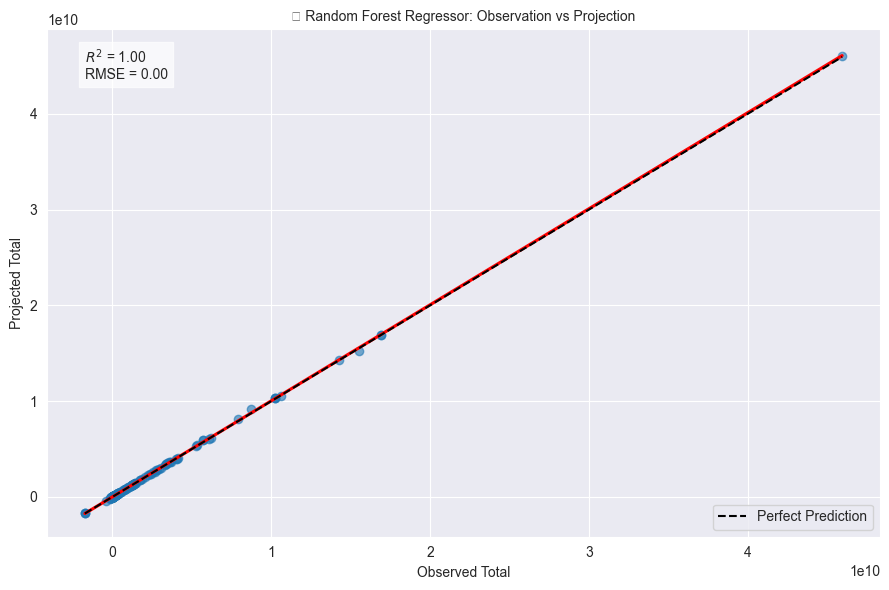

In [317]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Split Data
X_training, X_testing, y_training, y_testing = train_test_split( df_numeric.values, target, random_state = 42 )

# Fit & Predict
rf_reg = RandomForestRegressor( n_estimators = 100, random_state = 42 )
rf_reg.fit( X_training, y_training )
y_pred_rf_reg = rf_reg.predict( X_testing )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {rf_reg.score( X_training, y_training ):.1%}'
testing_score = f'Testing Score:  {rf_reg.score( X_testing, y_testing ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_rf_reg )
rmse = mean_squared_error( y_testing, y_pred_rf_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = (9, 6) )
sns.regplot( x = y_testing, y = y_pred_rf_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 10, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Observed Total' )
plt.ylabel( 'Projected Total' )
plt.title( '🌳 Random Forest Regressor: Observation vs Projection', fontsize = 10 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 🌲 Random Forest Classification
- This confusion matrix reflects classification performance on predicting whether Outlays are above or below the median.
- Uses majority voting from 100 decision trees for classification.
- Robust to outliers and noise with high accuracy and feature importance insight.
- Diagonal values represent correct classifications.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 100.0%
Testing Score:  100.0%




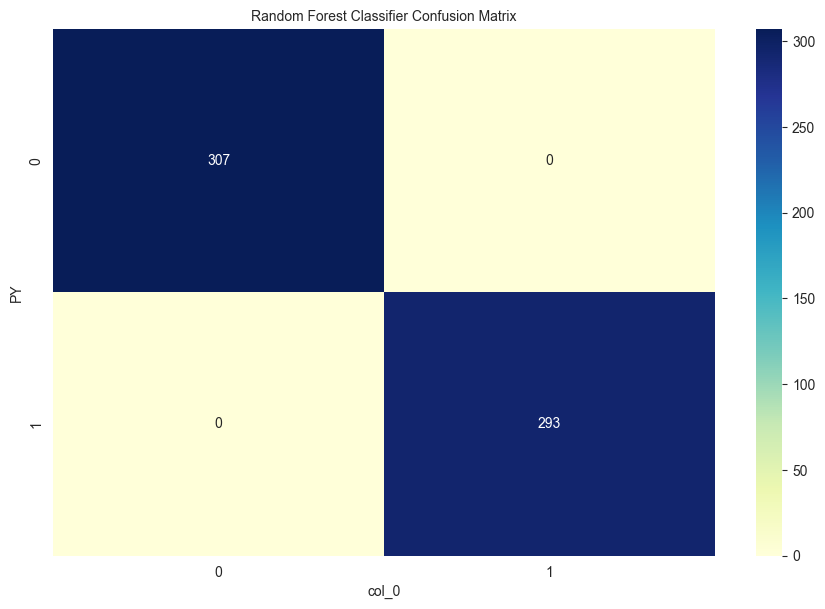

In [174]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split( df_numeric.values, classifier,
	random_state = 42 )

# Fit & Predict
rf_cls = RandomForestClassifier( n_estimators = 100, random_state = 42 )
rf_cls.fit( X_train_cls, y_train_cls )
y_pred_rf_cls = rf_cls.predict( X_test_cls )

print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {rf_cls.score( X_train_cls, y_train_cls ):.1%}'
testing_score = f'Testing Score:  {rf_cls.score( X_test_cls, y_test_cls ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

plt.figure( figsize = (9, 6) )
sns.heatmap( pd.crosstab( y_test_cls, y_pred_rf_cls ), annot = True, fmt = 'd', cmap = 'YlGnBu' )
plt.tight_layout( )
plt.title( 'Random Forest Classifier Confusion Matrix', fontsize = 10 )
plt.grid( False )
plt.show( )

## 🌲 Random Forest Learning-Curve
- Plots model performance vs. training set size.

###### Use:
- Diagnose underfitting/overfitting
- Understand model generalization

###### Results:
- Model accuracy vs. training set size
- Helps diagnose bias vs. variance

###### Inference:
- If training and validation scores converge at low accuracy → underfitting
- If wide gap → overfitting
- Plateau at high accuracy → enough data for generalization

###### Impact:
- Confirms whether current budget dataset size (e.g., number of accounts or agencies) is adequate to model execution behavior.
- Can reveal if more fiscal years, program types, or fund categories are needed.


------------------------------------------------------------------------------------------------------------------------





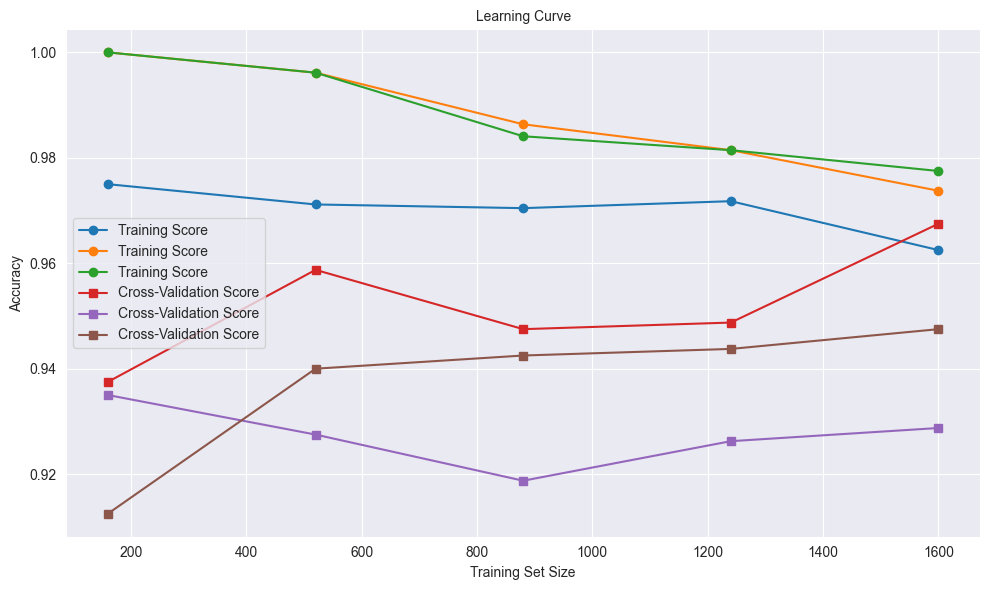

In [178]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( rf_cls, df_normalized.values, classifier, cv=3,
	scoring = 'accuracy' )
print( hdr )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.plot( train_sizes, train_scores, label = 'Training Score', marker = 'o' )
plt.plot( train_sizes, test_scores, label = 'Cross-Validation Score', marker = 's' )
plt.title( 'Learning Curve', fontsize = 10 )
plt.xlabel( 'Training Set Size', fontsize = 10 )
plt.ylabel( 'Accuracy' )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 🌲 Random Forest Precision-Recall
- Plots Precision vs. Recall — especially useful for imbalanced classes.

###### Use:
- Understand how precision and recall trade off
- Choose optimal threshold

###### Results:
- Trade-off between Precision (purity of High Execution predictions) and Recall (completeness of High Execution predictions)

###### Inference:
- When recall is high but precision is low → the model finds most efficient accounts, but also mislabels many inefficients.
- A "bump" in the curve can suggest score thresholds that yield better balance.

###### Impact:
- If precision drops sharply after a threshold, agencies may want to set alert thresholds at higher confidence levels to reduce false flags.

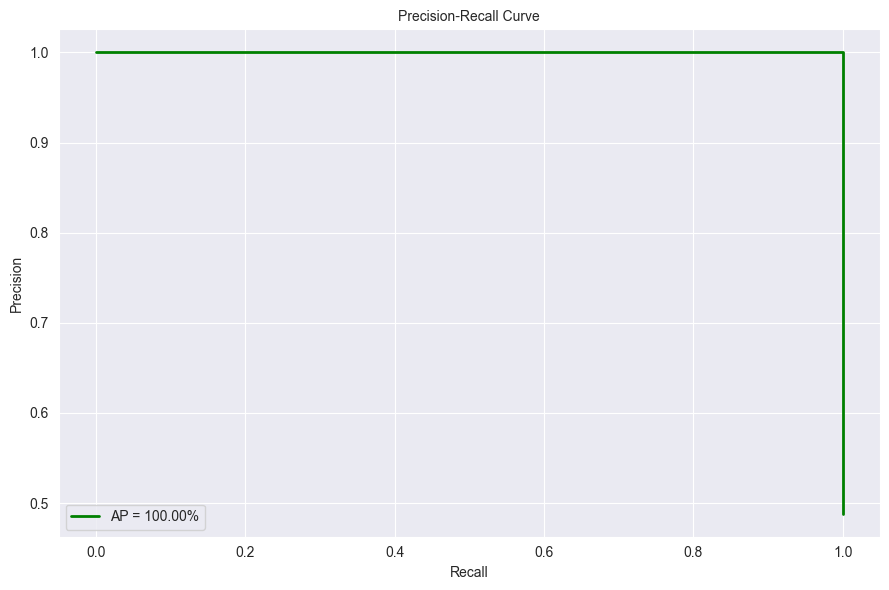

In [179]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve( y_test_cls, y_pred_rf_cls )
avg_precision = average_precision_score( y_test_cls, y_pred_rf_cls )

plt.figure( figsize = (9, 6) )
plt.plot( recall, precision, color = 'green', lw = 2, label = f'AP = {avg_precision:.2%}' )
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-Recall Curve', fontsize = 10 )
plt.legend( )
plt.tight_layout( )
plt.show( )


## 🌟 Gradient-Boosting Regression
> This scatterplot visualizes the predictions made by a Gradient Boosting Regressor for TotalResources.

- Builds sequential decision trees, each one correcting the errors of its predecessor.
- Optimizes a loss function (e.g., mean squared error) via gradient descent.
- More accurate and robust than single models, especially for complex, nonlinear relationships.
- Can overfit if not carefully tuned (e.g., learning rate, tree depth).


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 100.0%
Testing Score:  100.0%




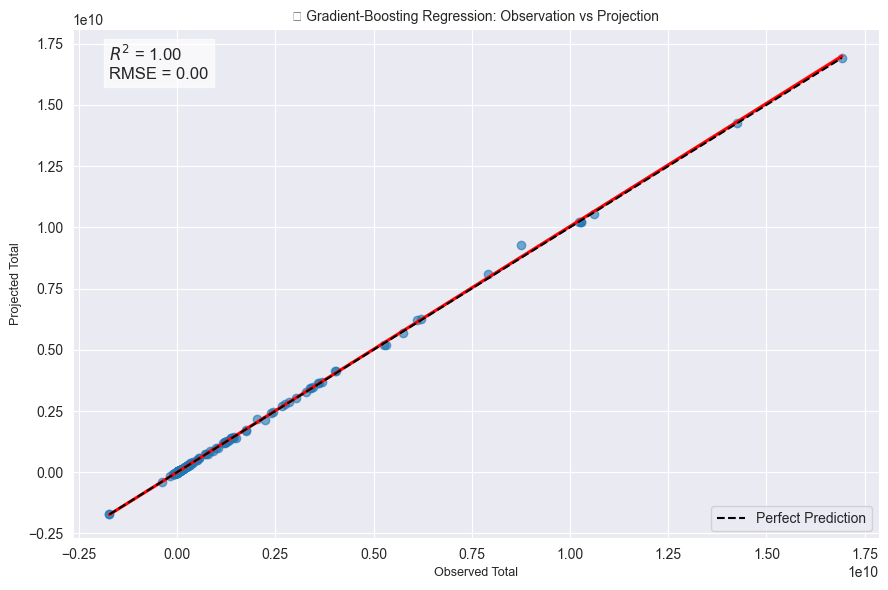

In [181]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
gb_data = scaler.fit_transform( df_numeric.values )

# Split Data
X_training, X_testing, y_training, y_testing = train_test_split( gb_data, target, test_size = 0.2,
	random_state = 42 )

# Train & Fit Model
gb_regressor = GradientBoostingRegressor( n_estimators = 100, random_state = 42 )
gb_regressor.fit( X_training, y_training )

# Predict
y_pred_gb_reg = gb_regressor.predict( X_testing )
mse_gb = mean_squared_error( y_training, gb_regressor.predict( X_training ) )
print( hdr )
print( 'Model Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {gb_regressor.score( X_training, y_training ):.1%}'
testing_score = f'Testing Score:  {gb_regressor.score( X_testing, y_testing ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_gb_reg )
rmse = mean_squared_error( y_testing, y_pred_gb_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = (9, 6) )
sns.regplot( x = y_testing, y = y_pred_gb_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Observed Total', fontsize = 9 )
plt.ylabel( 'Projected Total', fontsize = 9 )
plt.title( '🌳 Gradient-Boosting Regression: Observation vs Projection', fontsize = 10 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 🌟 Gradient-Boosting Classification
> This confusion matrix reflects the performance predicting whether Outlays are above or below the median.

- Sequentially adds trees to improve misclassified samples from earlier iterations.
- Highly effective on imbalanced or noisy classification tasks.
- Performs internal feature selection while minimizing prediction error.
- Slower than Random Forests but often yields better predictive accuracy.


------------------------------------------------------------------------------------------------------------------------

Model Performance


Training Score: 89.2%
Testing Score:  87.5%




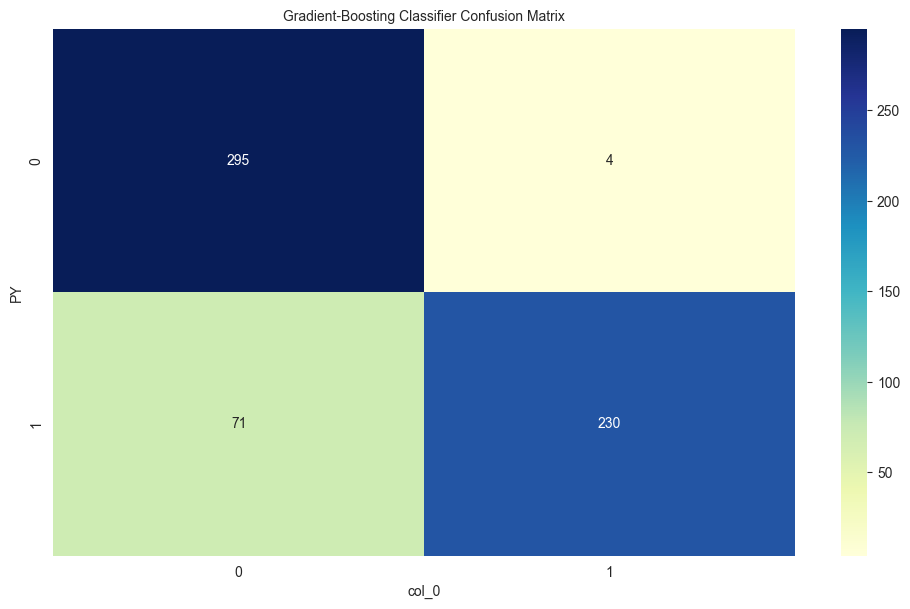

In [186]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric columns for modeling." )

# Prepare values for regression and classification
values = df_normalized.iloc[ :, 1: ]
target = df_normalized.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
gb_cls_data = scaler.fit_transform( values )

# Split values
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split( gb_cls_data, classifier,
	random_state = 42 )

# Fit & Predict
gb_classifier = GradientBoostingClassifier( n_estimators = 100, random_state = 42 )
gb_classifier.fit( X_train_cls, y_train_cls )
y_pred_gb_cls = gb_classifier.predict( X_test_cls )

# Score Model
training_score = f'Training Score: {gb_classifier.score( X_train_cls, y_train_cls ):.1%}'
testing_score = f'Testing Score:  {gb_classifier.score( X_test_cls, y_test_cls ):.1%}'
print( hdr )
print( 'Model Performance' )
print( nwln )
print( training_score )
print( testing_score )
print( nwln )

plt.figure( figsize = (10, 6) )
sns.heatmap( pd.crosstab( y_test_cls, y_pred_gb_cls ), annot = True, fmt = 'd', cmap = 'YlGnBu' )
plt.tight_layout( )
plt.title( 'Gradient-Boosting Classifier Confusion Matrix', fontsize = 10 )
plt.grid( False )

## 🌟 Gradient-Boosting Precision-Recall
- Plots Precision vs. Recall — especially useful for imbalanced classes.

###### Use:
- Understand how precision and recall trade off
- Choose optimal threshold

###### Results:
- Trade-off between Precision (purity of High Execution predictions) and Recall (completeness of High Execution predictions)

###### Inference:
- When recall is high but precision is low → the model finds most efficient accounts, but also mislabels many inefficients.
- A "bump" in the curve can suggest score thresholds that yield better balance.

###### Impact:
- If precision drops sharply after a threshold, agencies may want to set alert thresholds at higher confidence levels to reduce false flags.

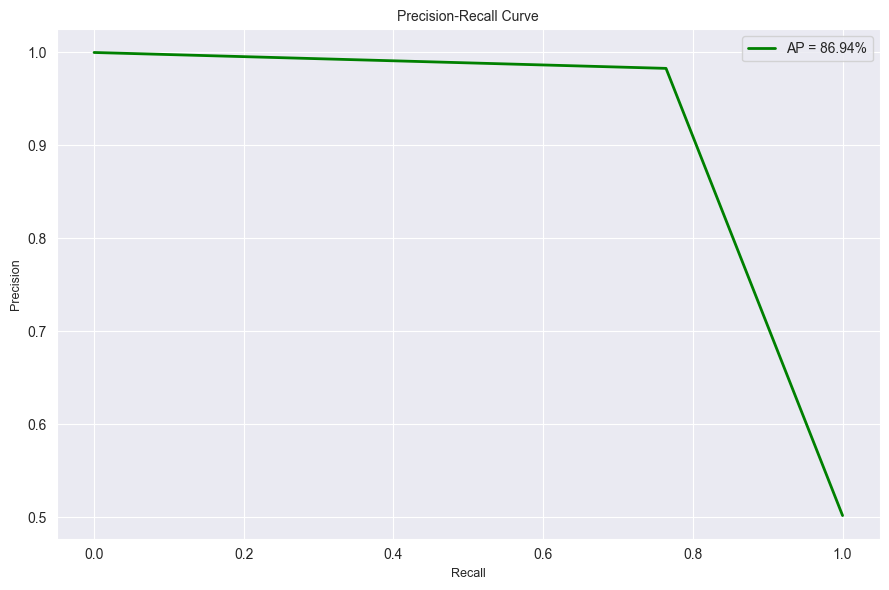

In [187]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve( y_test_cls, y_pred_gb_cls )
avg_precision = average_precision_score( y_test_cls, y_pred_gb_cls )
plt.figure( figsize = (9, 6) )
plt.plot( recall, precision, color = 'green', lw = 2, label = f'AP = {avg_precision:.2%}' )
plt.xlabel( 'Recall', fontsize = 9 )
plt.ylabel( 'Precision', fontsize = 9 )
plt.title( 'Precision-Recall Curve', fontsize = 10 )
plt.legend( )
plt.tight_layout( )
plt.show( )

## 🌟 Gradient-Boosting Learning Curve

- Plots model performance vs. training set size.

###### Use:
- Diagnose underfitting/overfitting
- Understand model generalization

###### Results:
- Model accuracy vs. training set size
- Helps diagnose bias vs. variance

###### Inference:
- If training and validation scores converge at low accuracy → underfitting
- If wide gap → overfitting
- Plateau at high accuracy → enough data for generalization

###### Impact:
- Confirms whether current budget dataset size (e.g., number of accounts or agencies) is adequate to model execution behavior.
- Can reveal if more fiscal years, program types, or fund categories are needed.
___


------------------------------------------------------------------------------------------------------------------------

Gradient-Boosting Learning Curve Accuracay




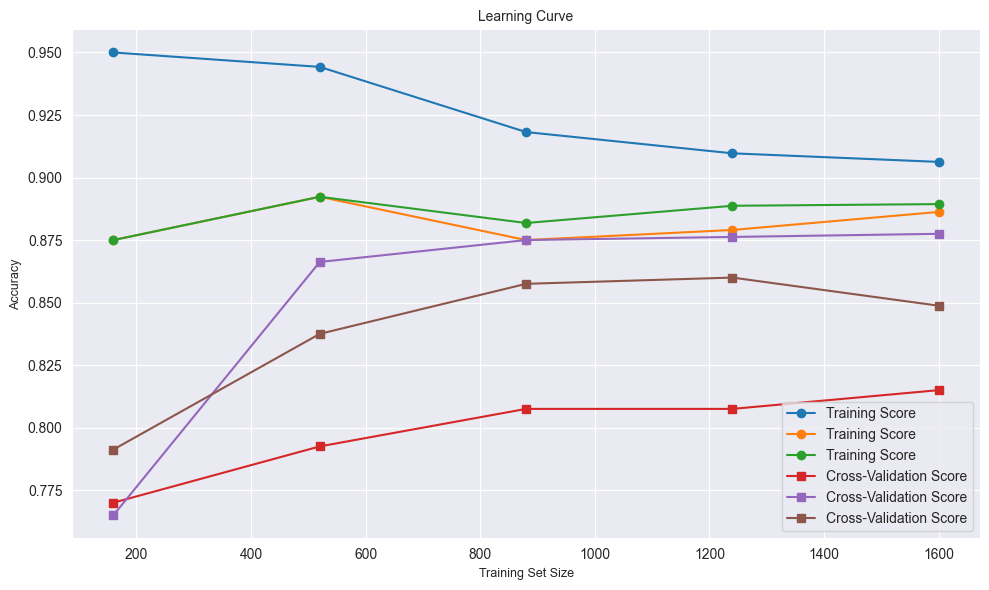

In [190]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( gb_classifier, gb_cls_data, classifier, cv = 3,
	scoring = 'accuracy' )
print( hdr )
print( 'Gradient-Boosting Learning Curve Accuracay' )
print( nwln )

plt.figure( figsize=( 10, 6 ) )
plt.plot( train_sizes, train_scores, label = 'Training Score', marker = 'o' )
plt.plot( train_sizes, test_scores, label = 'Cross-Validation Score', marker = 's' )
plt.title( 'Learning Curve', fontsize = 10 )
plt.xlabel( 'Training Set Size', fontsize = 9 )
plt.ylabel( 'Accuracy', fontsize = 9 )
plt.legend( loc='best')
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 🔢 Ridge Regression
- This scatterplot shows the actual values versus the predicted values from the Ridge Regressor.
- The closer the points are to the diagonal, the better the model's prediction performance.
___


------------------------------------------------------------------------------------------------------------------------

Training Score: 61.1%
Testing Score:  39.9%
Regularization: 0.001




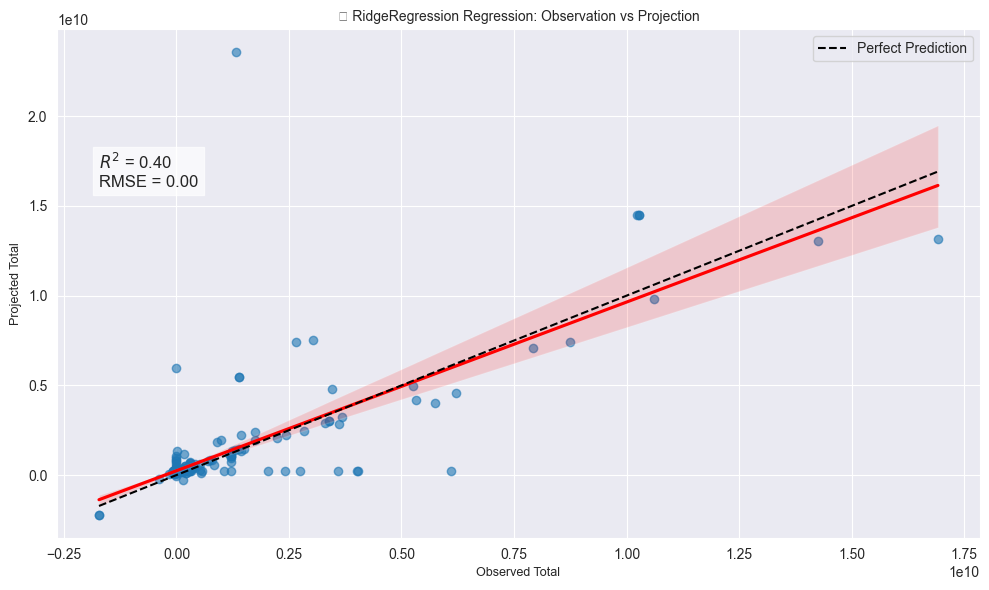

In [263]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_training, X_testing, y_training, y_testing = train_test_split( data, target, test_size = 0.2,
	random_state = 42 )

# Fit & Predict
ridge_reg = Ridge( alpha=0.001, max_iter=10000 )
ridge_reg.fit( X_training, y_training )
y_pred_reg = ridge_reg.predict( X_testing )

# Score Model
training_score = f'Training Score: {ridge_reg.score( X_training, y_training ):.1%}'
testing_score = f'Testing Score:  {ridge_reg.score( X_testing, y_testing ):.1%}'
ridge_alpha = f'Regularization: {ridge_reg.alpha}'

print( hdr )
print( training_score )
print( testing_score )
print( ridge_alpha )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_reg )
rmse = mean_squared_error( y_testing, y_pred_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = ( 10, 6 ) )
sns.regplot( x = y_testing, y = y_pred_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Observed Total', fontsize = 9 )
plt.ylabel( 'Projected Total', fontsize = 9 )
plt.title( '🌳 RidgeRegression Regression: Observation vs Projection', fontsize = 10 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )


------------------------------------------------------------------------------------------------------------------------

Ridge Regression
Training Score / Testing Score




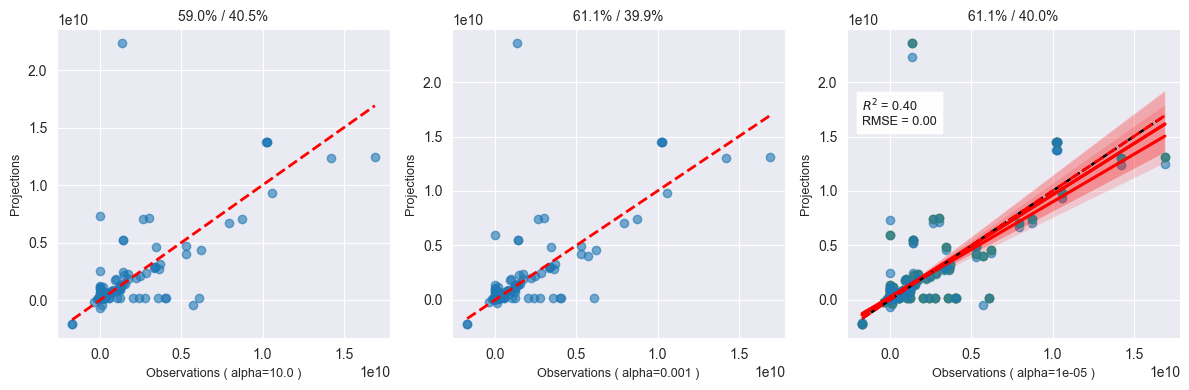

In [223]:
print( hdr )
print( 'Ridge Regression' )
print( 'Training Score / Testing Score' )
print( nwln )

# Prepare figure for 3 subplots
fig, axes = plt.subplots( 1, 3, figsize = (12, 4) )
alphas = [ 10., .001, 0.00001 ]

# Train and plot for each alpha
for i, alpha in enumerate( alphas ):
	# Fit & Predict
	ridge = Ridge( alpha=alpha, max_iter=10000 )
	ridge.fit( X_training, y_training )
	y_pred_ridge = ridge.predict( X_testing )
	r2 = r2_score( y_testing, y_pred_ridge )
	training_score = f'{ridge.score( X_training, y_training ):.1%}'
	testing_score = f'{ridge.score( X_testing, y_testing ):.1%}'
	rmse = mean_squared_error( y_testing, y_pred_ridge )
	if rmse > 100000000:
		rmse = 0.0
	sns.regplot( x = y_testing, y = y_pred_ridge, scatter_kws = { 'alpha': 0.6 },
		line_kws = { 'color': 'red' } )
	plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
		label = 'Perfect Prediction' )
	plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
		s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
		fontsize = 9, bbox = dict( facecolor = 'white', alpha = 0.7 ) )

	# Plot predictions
	axes[ i ].scatter( y_testing, y_pred_ridge, alpha = 0.6 )
	axes[ i ].plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ],
		'r--', lw = 2 )
	axes[ i ].set_title( f'{training_score} / {testing_score}', fontsize = 10 )
	axes[ i ].set_xlabel( f'Observations ( alpha={alpha} )', fontsize = 9 )
	axes[ i ].set_ylabel( 'Projections', fontsize = 9 )
	axes[ i ].grid( True )

plt.tight_layout( )
plt.show( )

## 🔢 Ridge Classification
- This confusion matrix compares the predicted class labels to the actual class labels.
- The Ridge Classifier was trained to classify values above or below the median as binary classes (1 or 0).
- Diagonal values show correct classifications, while off-diagonal values indicate misclassifications.

___


------------------------------------------------------------------------------------------------------------------------

Training Score: 76.4%
Testing  Score:  73.5%
Regularization: 0.001




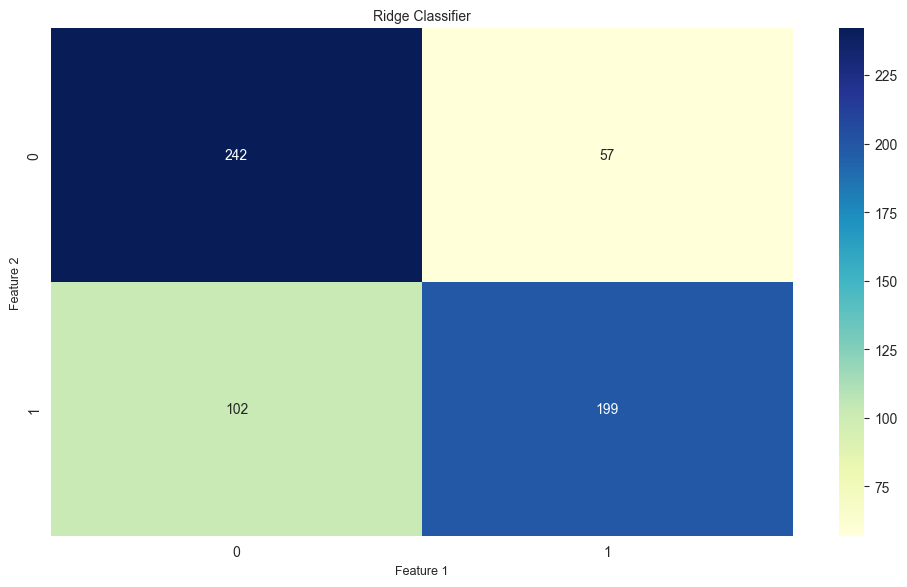

In [264]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_normalized.iloc[ :, 1: ]
target = df_normalized.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )
# Split Data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split( data, classifier,
	random_state = 42 )

# Fit & Predict
ridge_cls = RidgeClassifier( alpha=0.001 )
ridge_cls.fit( X_train_cls, y_train_cls )
y_pred_ridge_cls = ridge_cls.predict( X_test_cls )

# Score Model
training_score = f'Training Score: {ridge_cls.score( X_train_cls, y_train_cls ):.1%}'
testing_score = f'Testing  Score:  {ridge_cls.score( X_test_cls, y_test_cls ):.1%}'
ridge_alpha = f'Regularization: {ridge_cls.alpha}'

print( hdr )
print( training_score )
print( testing_score )
print( ridge_alpha)
print( nwln )

# Plot RidgeRegression Classifier
plt.figure( figsize = (10, 6) )
sns.heatmap( pd.crosstab( y_test_cls, y_pred_ridge_cls ), annot = True, fmt = 'd', cmap = 'YlGnBu' )
plt.title( f'Ridge Classifier', fontsize = 10 )
plt.tight_layout( )
plt.xlabel( 'Feature 1', fontsize = 9 )
plt.ylabel( 'Feature 2', fontsize = 9 )
plt.show( )

## 🔢 Ridge Learning-Curve
- Plots model performance vs. training set size.

###### Use:
- Diagnose underfitting/overfitting
- Understand model generalization

###### Results:
- Model accuracy vs. training set size
- Helps diagnose bias vs. variance

###### Inference:
- If training and validation scores converge at low accuracy → underfitting
- If wide gap → overfitting
- Plateau at high accuracy → enough data for generalization

###### Impact:
- Confirms whether current budget dataset size (e.g., number of accounts or agencies) is adequate to model execution behavior.
- Can reveal if more fiscal years, program types, or fund categories are needed.

___


------------------------------------------------------------------------------------------------------------------------

Ridge Learning Curves




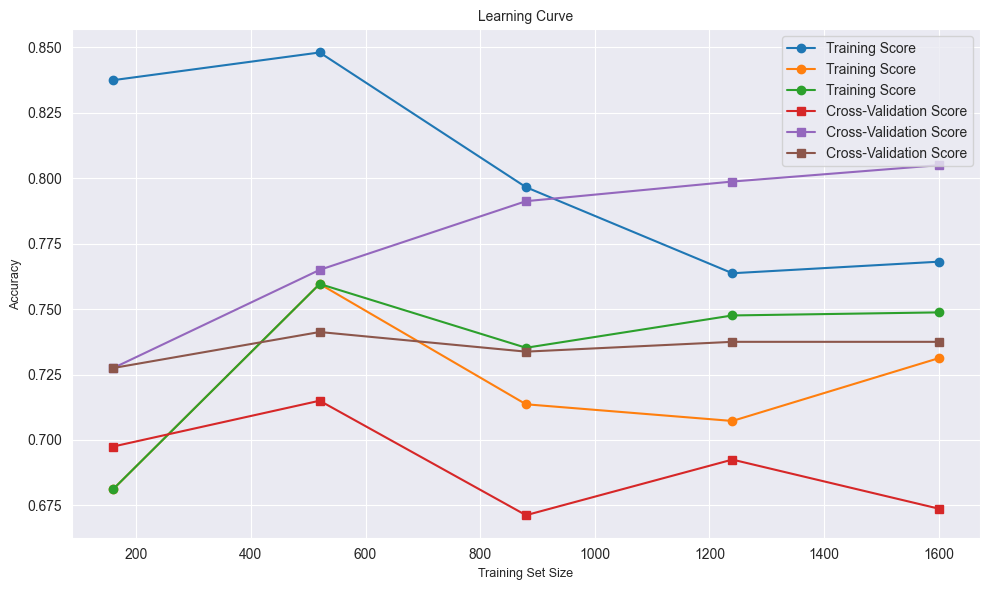

In [200]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( ridge_cls, data, classifier, cv = 3,
	scoring = 'accuracy' )
print( hdr )
print( 'Ridge Learning Curves')
print( nwln )

plt.figure( figsize = ( 10, 6 ) )
plt.plot( train_sizes, train_scores, label = 'Training Score', marker = 'o' )
plt.plot( train_sizes, test_scores, label = 'Cross-Validation Score', marker = 's' )
plt.title( 'Learning Curve', fontsize = 10 )
plt.xlabel( 'Training Set Size', fontsize = 9 )
plt.ylabel( 'Accuracy', fontsize = 9 )
plt.legend( loc='upper right' )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 🔢 Ridge Precision-Recall
- Plots Precision vs. Recall — especially useful for imbalanced classes.

###### Use:
- Understand how precision and recall trade off
- Choose optimal threshold

###### Results:
- Trade-off between Precision (purity of High Execution predictions) and Recall (completeness of High Execution predictions)

###### Inference:
- When recall is high but precision is low → the model finds most efficient accounts, but also mislabels many inefficients.
- A "bump" in the curve can suggest score thresholds that yield better balance.

###### Impact:
- If precision drops sharply after a threshold, agencies may want to set alert thresholds at higher confidence levels to reduce false flags.

___

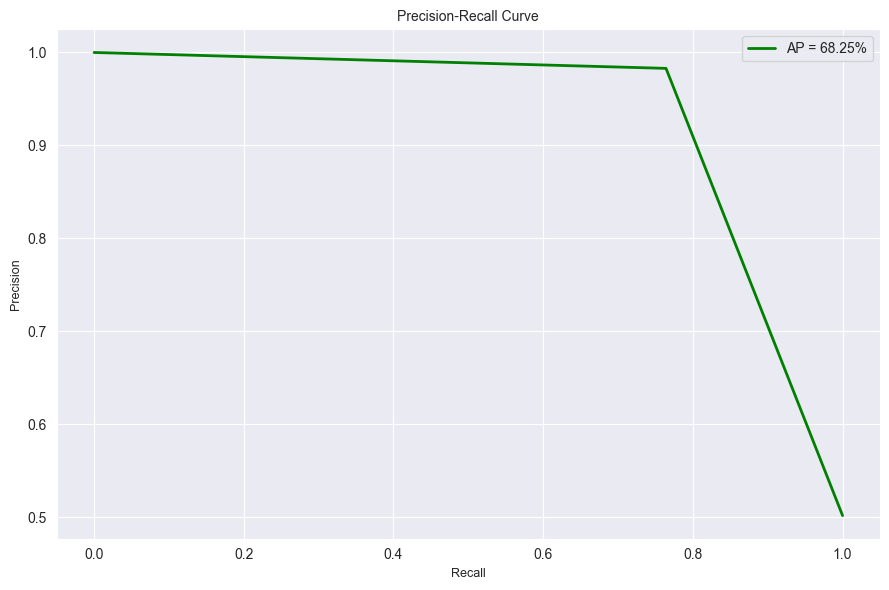

In [201]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve( y_test_cls, y_pred_gb_cls )
avg_precision = average_precision_score( y_test_cls, y_pred_ridge_cls )
plt.figure( figsize = (9, 6) )
plt.plot( recall, precision, color = 'green', lw = 2, label = f"AP = {avg_precision:.2%}" )
plt.xlabel( 'Recall', fontsize = 9 )
plt.ylabel( 'Precision', fontsize = 9 )
plt.title( 'Precision-Recall Curve', fontsize = 10 )
plt.legend( )
plt.tight_layout( )
plt.show( )

## 📊 K-Nearest Neighbors Regression:
- This scatterplot compares actual values to the predicted values using a KNN regressor.
- The model makes predictions by averaging the outputs of the 5 nearest data points in feature space.

___


------------------------------------------------------------------------------------------------------------------------

k-NN Regression Performance


Training Score: 65.7%
Testing  Score:  86.3%
Neighbors Used: 3




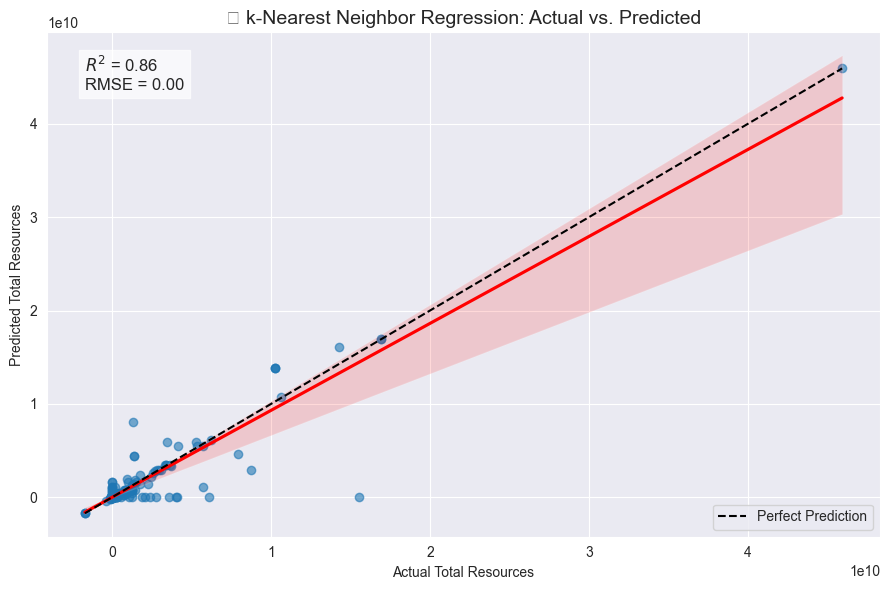

In [175]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_numeric.iloc[ :, 1: ]
target = df_numeric.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
knn_data = scaler.fit_transform( values )

# Split values
X_training, X_testing, y_training, y_testing = train_test_split( knn_data, target, random_state = 42 )

# Train, fit & predict
knn_reg = KNeighborsRegressor( n_neighbors = 3 )
knn_reg.fit( X_training, y_training )
y_pred_knn_reg = knn_reg.predict( X_testing )
print( hdr )
print( 'k-NN Regression Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {knn_reg.score( X_training, y_training ):.1%}'
testing_score = f'Testing  Score:  {knn_reg.score( X_testing, y_testing ):.1%}'
neighbors_used = f'Neighbors Used: {knn_reg.n_neighbors}'
print( training_score )
print( testing_score )
print( neighbors_used )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_knn_reg )
rmse = mean_squared_error( y_testing, y_pred_knn_reg )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = (9, 6) )
sns.regplot( x = y_testing, y = y_pred_knn_reg, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Actual Total Resources' )
plt.ylabel( 'Predicted Total Resources' )
plt.title( '🌳 k-Nearest Neighbor Regression: Actual vs. Predicted', fontsize = 14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 📊 K-Nearest Neighbors Classification
- This heatmap shows classification performance, identifying whether a value is above or below the median.
- Each prediction is based on a majority vote from the 5 nearest neighbors.
-
___



------------------------------------------------------------------------------------------------------------------------

k-NN Classification Performance


Training Score: 72.3%
Testing  Score:  71.5%




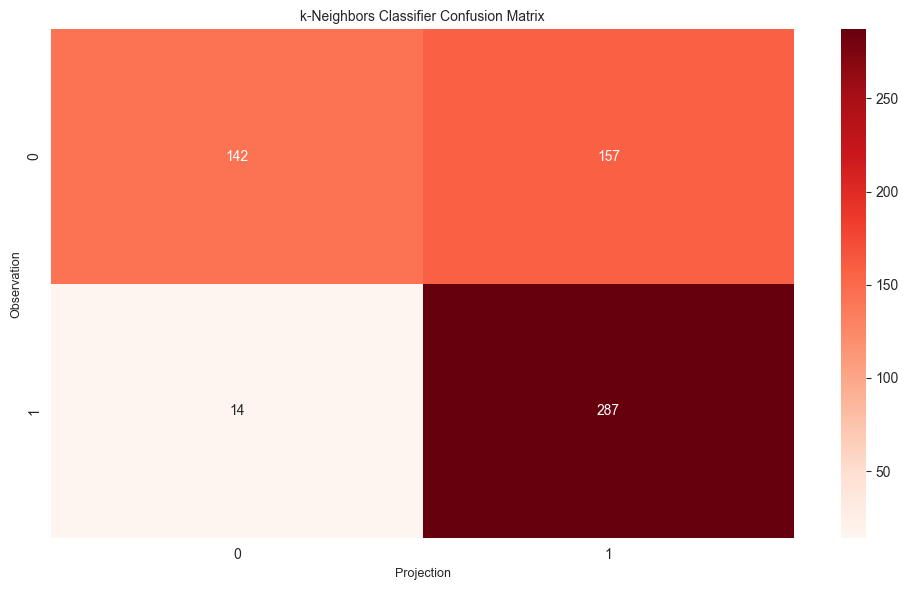

In [203]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric columns for modeling." )

# Prepare values for regression and classification
values = df_normalized.iloc[ :, 1: ]
target = df_normalized.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
data = scaler.fit_transform( values )

# Split values
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split( data, classifier,
	random_state = 42 )

# Fit & Predict
knn_cls = KNeighborsClassifier( n_neighbors = 5 )
knn_cls.fit( X_train_cls, y_train_cls )
y_pred_knn_cls = knn_cls.predict( X_test_cls )
print( hdr )
print( 'k-NN Classification Performance' )
print( nwln )

# Score Model
training_score = f'Training Score: {knn_cls.score( X_train_cls, y_train_cls ):.1%}'
testing_score = f'Testing  Score:  {knn_cls.score( X_test_cls, y_test_cls ):.1%}'
print( training_score )
print( testing_score )
print( nwln )

# Plot KNN Classifier
plt.figure( figsize = (10, 6) )
sns.heatmap( pd.crosstab( y_test_cls, y_pred_knn_cls ), annot = True, fmt = 'd', cmap = 'Reds' )
plt.xlabel( 'Projection', fontsize = 9 )
plt.ylabel( 'Observation', fontsize = 9 )
plt.title( 'k-Neighbors Classifier Confusion Matrix', fontsize = 10 )
plt.tight_layout( )
plt.show( )

## 📊 K-Nearest Neighbors Learning-Curve

- Plots model performance vs. training set size.

###### Use:
- Diagnose underfitting/overfitting
- Understand model generalization

###### Results:
- Model accuracy vs. training set size
- Helps diagnose bias vs. variance

###### Inference:
- If training and validation scores converge at low accuracy → underfitting
- If wide gap → overfitting
- Plateau at high accuracy → enough data for generalization

###### Impact:
- Confirms whether current budget dataset size (e.g., number of accounts or agencies) is adequate to model execution behavior.
- Can reveal if more fiscal years, program types, or fund categories are needed.
___


------------------------------------------------------------------------------------------------------------------------





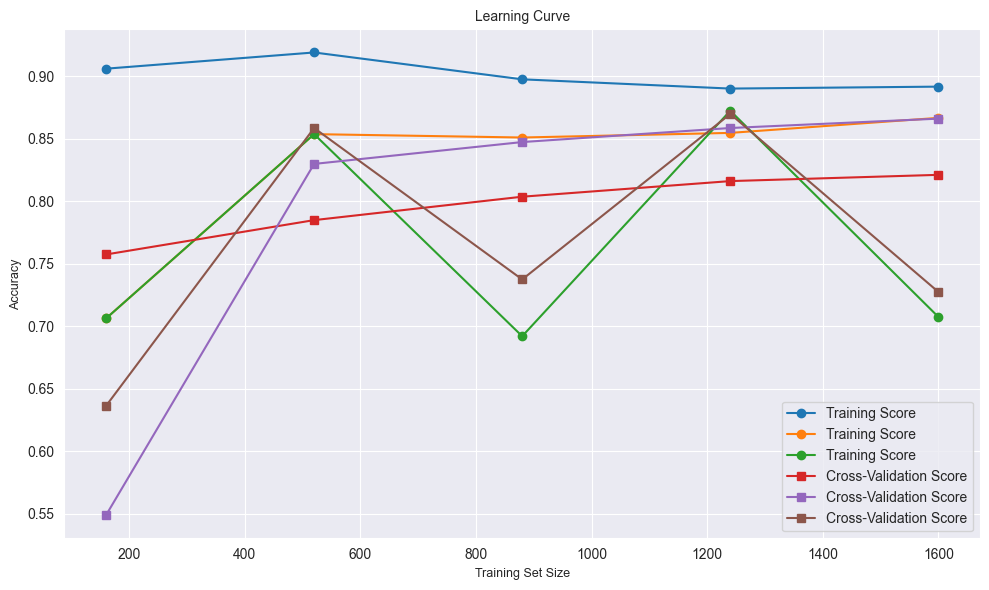

In [205]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( knn_cls, data, classifier, cv = 3,
	scoring = 'accuracy' )
print( hdr )
print( nwln )

plt.figure( figsize = ( 10, 6 ) )
plt.plot( train_sizes, train_scores, label = 'Training Score', marker = 'o' )
plt.plot( train_sizes, test_scores, label = 'Cross-Validation Score', marker = 's' )
plt.title( 'Learning Curve', fontsize = 10 )
plt.xlabel( 'Training Set Size', fontsize = 9 )
plt.ylabel( 'Accuracy', fontsize = 9 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 📊 K-Nearest Neighbors Precision-Recall
- Plots Precision vs. Recall — especially useful for imbalanced classes.

###### Use:
- Understand how precision and recall trade off
- Choose optimal threshold

###### Results:
- Trade-off between Precision (purity of High Execution predictions) and Recall (completeness of High Execution predictions)

###### Inference:
- When recall is high but precision is low → the model finds most efficient accounts, but also mislabels many inefficients.
- A "bump" in the curve can suggest score thresholds that yield better balance.

###### Impact:
- If precision drops sharply after a threshold, agencies may want to set alert thresholds at higher confidence levels to reduce false flags.

___

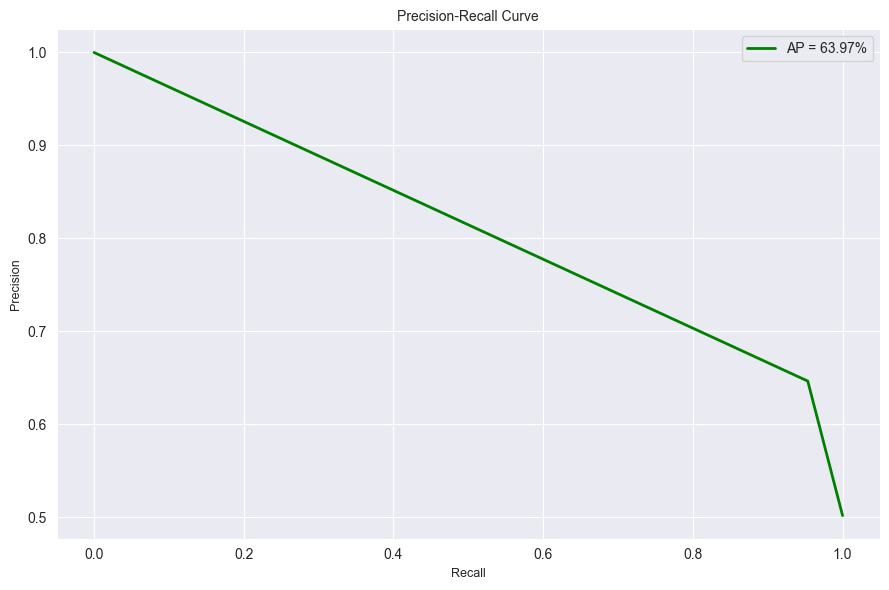

In [206]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve( y_test_cls, y_pred_knn_cls )
avg_precision = average_precision_score( y_test_cls, y_pred_knn_cls )
plt.figure( figsize = (9, 6) )
plt.plot( recall, precision, color = 'green', lw = 2, label = f'AP = {avg_precision:.2%}' )
plt.xlabel( 'Recall', fontsize = 9 )
plt.ylabel( 'Precision', fontsize = 9 )
plt.title( 'Precision-Recall Curve', fontsize = 10 )
plt.legend( )
plt.tight_layout( )
plt.show( )

## 📈 Support Vector Machine Regression
- This plot shows how SVR approximates the true values using a non-linear kernel (rbf).
- SVR tries to fit the data within a margin of tolerance rather than minimizing mean squared error directly.


------------------------------------------------------------------------------------------------------------------------

Training Score: 35.4%
Testing  Score:  34.6%
Slack : 10




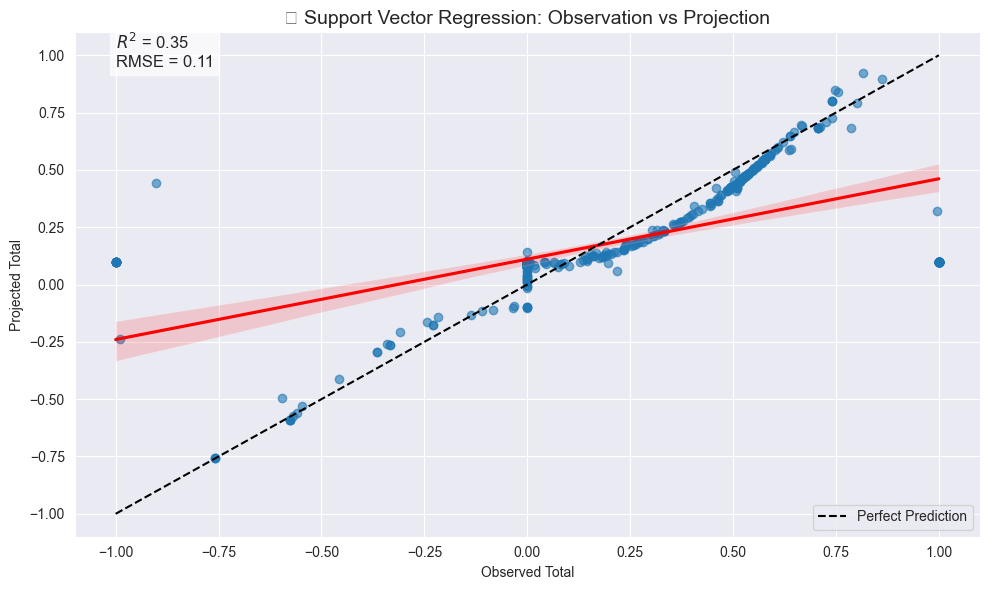

In [353]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( 'Not enough numeric columns for modeling.' )

# Prepare values for regression and classification
values = df_normalized.iloc[ :, 1: ]
target = df_normalized.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
svm_data = scaler.fit_transform( values )

# Split values
X_training, X_testing, y_training, y_testing = train_test_split( svm_data, target, test_size=0.2,
	random_state=42 )

# Support Vector Regressor: Fit & Predict
svr_model = SVR( kernel='rbf', C=10 )
svr_model.fit( X_training, y_training )
y_pred_svr = svr_model.predict( X_testing )

# Score Model
training_score = f'Training Score: {svr_model.score( X_training, y_training ):.1%}'
testing_score = f'Testing  Score:  {svr_model.score( X_testing, y_testing ):.1%}'
slack = f'Slack : {svr_model.C}'

print( hdr )
print( training_score )
print( testing_score )
print( slack )
print( nwln )

# === Regression Plot ===
r2 = r2_score( y_testing, y_pred_svr )
rmse = mean_squared_error( y_testing, y_pred_svr )
if rmse > 100000000:
	rmse = 0.0
plt.figure( figsize = ( 10, 6 ) )
sns.regplot( x = y_testing, y = y_pred_svr, scatter_kws = { 'alpha': 0.6 },
	line_kws = { 'color': 'red' } )
plt.plot( [ y_testing.min( ), y_testing.max( ) ], [ y_testing.min( ), y_testing.max( ) ], 'k--',
	label = 'Perfect Prediction' )
plt.text( x = y_testing.min( ), y = y_testing.max( ) * 0.95,
	s = f'$R^2$ = {r2:.2f}\nRMSE = {rmse:.2f}',
	fontsize = 12, bbox = dict( facecolor = 'white', alpha = 0.7 ) )
plt.xlabel( 'Observed Total' )
plt.ylabel( 'Projected Total' )
plt.title( '🌳 Support Vector Regression: Observation vs Projection', fontsize = 14 )
plt.legend( )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 📈 Support Vector Machine Classification
- This heatmap visualizes how well SVC classifies values above or below the median.
- SVC constructs hyperplanes in a high-dimensional space to separate the classes.


------------------------------------------------------------------------------------------------------------------------

Training Score: 86.0%
Testing  Score:  85.1%
Slack:  10




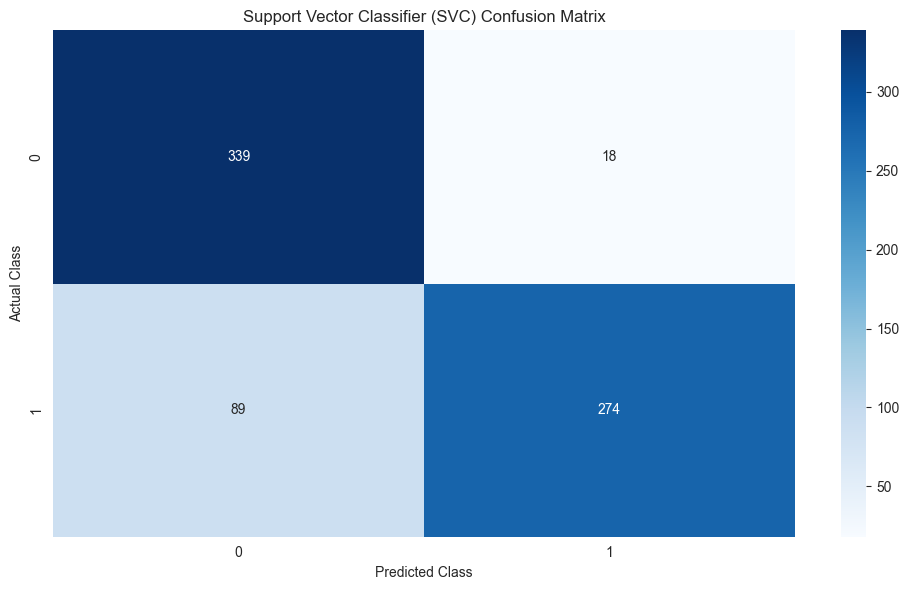

In [359]:
# Ensure there are at least two columns for modeling
if df_numeric.shape[ 1 ] < 2:
	raise ValueError( "Not enough numeric data for modeling." )

# Prepare values for regression and classification
values = df_normalized.iloc[ :, 1: ]
target = df_normalized.iloc[ :, 0 ]
classifier = (target > target.median( )).astype( int )

# Standardize features
scaler = StandardScaler( )
svc_data = scaler.fit_transform( values )

# Split values
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split( svc_data, classifier,
	test_size=0.3, random_state=42 )

# Fit & Predict
svc_cls = SVC( kernel='rbf', C=10  )
svc_cls.fit( X_train_cls, y_train_cls )
y_pred_svc_cls = svc_cls.predict( X_test_cls )

# Score Model
training_score = f'Training Score: {svc_cls.score( X_train_cls, y_train_cls ):.1%}'
testing_score = f'Testing  Score:  {svc_cls.score( X_test_cls, y_test_cls ):.1%}'
C_score = f'Slack:  {svc_cls.C}'

print( hdr )
print( training_score )
print( testing_score )
print( C_score )
print( nwln )

# Plot SVC
plt.figure( figsize = (10, 6) )
sns.heatmap( pd.crosstab( y_test_cls, y_pred_svc_cls ), annot = True, fmt = "d", cmap = "Blues" )
plt.xlabel( "Predicted Class" )
plt.ylabel( "Actual Class" )
plt.title( "Support Vector Classifier (SVC) Confusion Matrix" )
plt.tight_layout( )
plt.show( )

## 📈 Support Vector Machine Learning-Curve

- Plots model performance vs. training set size.

###### Use:
- Diagnose underfitting/overfitting
- Understand model generalization

###### Results:
- Model accuracy vs. training set size
- Helps diagnose bias vs. variance

###### Inference:
- If training and validation scores converge at low accuracy → underfitting
- If wide gap → overfitting
- Plateau at high accuracy → enough data for generalization

###### Impact:
- Confirms whether current budget dataset size (e.g., number of accounts or agencies) is adequate to model execution behavior.
- Can reveal if more fiscal years, program types, or fund categories are needed.
___


------------------------------------------------------------------------------------------------------------------------





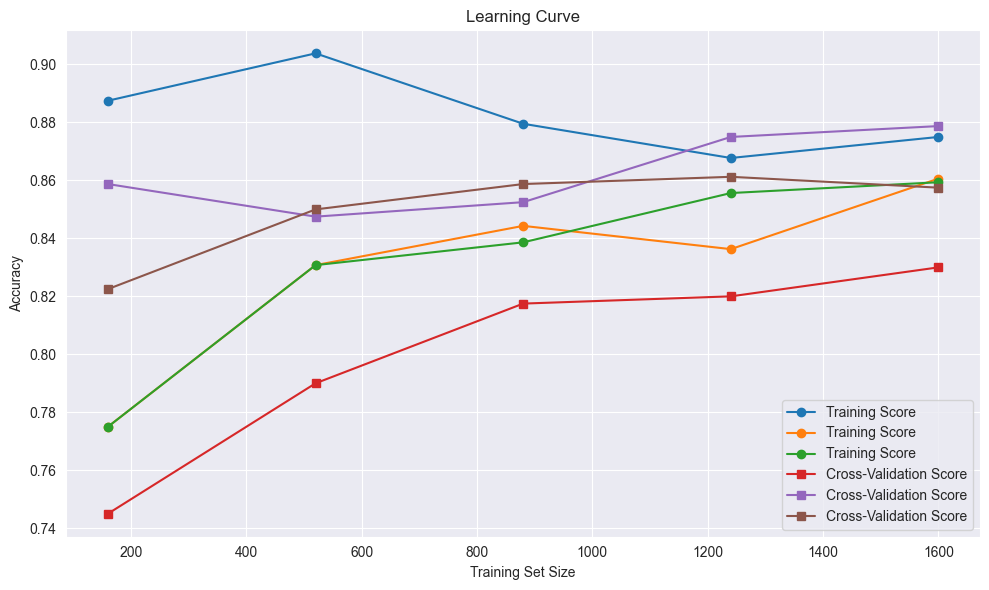

In [360]:
# Learning Curve Accuracy
train_sizes, train_scores, test_scores = learning_curve( svc_cls, data, classifier, cv = 3,
	scoring = 'accuracy' )
print( hdr )
print( nwln )

plt.figure( figsize = (10, 6) )
plt.plot( train_sizes, train_scores, label = 'Training Score', marker = 'o' )
plt.plot( train_sizes, test_scores, label = 'Cross-Validation Score', marker = 's' )
plt.title( 'Learning Curve' )
plt.xlabel( 'Training Set Size' )
plt.ylabel( 'Accuracy' )
plt.legend( loc='best' )
plt.grid( True )
plt.tight_layout( )
plt.show( )

## 📈 Support Vector Machine Precision-Recall
- Plots Precision vs. Recall — especially useful for imbalanced classes.

###### Use:
- Understand how precision and recall trade off
- Choose optimal threshold

###### Results:
- Trade-off between Precision (purity of High Execution predictions) and Recall (completeness of High Execution predictions)

###### Inference:
- When recall is high but precision is low → the model finds most efficient accounts, but also mislabels many inefficients.
- A "bump" in the curve can suggest score thresholds that yield better balance.

###### Impact:
- If precision drops sharply after a threshold, agencies may want to set alert thresholds at higher confidence levels to reduce false flags.

___

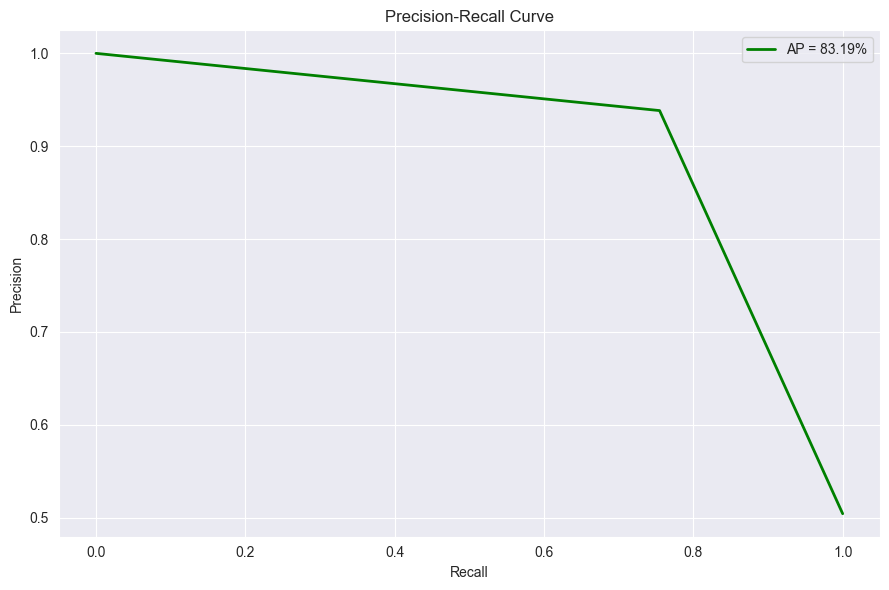

In [361]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve( y_test_cls, y_pred_svc_cls )
avg_precision = average_precision_score( y_test_cls, y_pred_svc_cls )
plt.figure( figsize = (9, 6) )
plt.plot( recall, precision, color = 'green', lw = 2, label = f"AP = {avg_precision:.2%}" )
plt.xlabel( "Recall" )
plt.ylabel( "Precision" )
plt.title( "Precision-Recall Curve" )
plt.legend( )
plt.tight_layout( )
plt.show( )

## Abstract


This study develops periodic predictive models for reporting and formulating estimates across the following domains on the Combined Schedule (X): Current Year (CY), Budget Year (BY), Out Year-1 (OY-1), to Out Year-9 (OY-10). Using an integrated schedule dataset (“CombinedSchedules.xlsx”) containing prior-year (PY), current-year (CY), budget-year (BY), and nine out-year projections by Main Account, LineName, and Line, we estimate separate models for each horizon. After basic quality controls (type coercion, missingness checks, and row exclusion where >40% of modeling fields are missing), we train candidate algorithms and select the best model by mean absolute error (MAE) on a holdout set. To avoid leakage, features are nested by horizon: CY←{PY}; BY←{PY, CY}; OY-1←{PY, CY, BY}; OY-2←{PY, CY, BY, OY-1}. In this environment, Gradient Boosting performed best for CY, k-Nearest Neighbors for BY, Support Vector Regression for OY-1, and Random Forests for OY-2. Diagnostics show strong PY→CY association, increasing dispersion at longer horizons, and residuals concentrated near zero with heavy-tail outliers in the largest programs. We provide practical implications for budget formulation, including portfolio-level reasonableness checks and horizon-specific method selection, and recommend extensions (categorical encoders, hierarchical models, quantile prediction, hyperparameter search, and policy-aware constraints) to improve operational accuracy and robustness.

## Introduction


Federal budget formulation requires timely estimates for the current execution year (CY), the year of the President’s Budget (BY), and multiple out years (OY). Program offices and budget analysts must produce horizon-specific forecasts at the account/line level that are internally consistent and defensible. We examine whether lightweight machine-learning models—trained only on information commonly available across schedules (PY, CY, BY, and immediate prior out-year fields)—can produce useful predictions for CY, BY, OY-1, and OY-2 that complement subject-matter adjustments and policy guidance.

## Background


**Data**. The study uses a consolidated schedule file with these modeling fields:

**Identifiers**: MainAccount, LineName, Line (categorical); CombinedSchedulesId (index).

**Numerics**: PY, CY, BY, and OY-1…OY-9 (float).

**Budget context**.
- PY is the last completed fiscal year;
- CY is the ongoing execution year;
- BY is the budget submission year;
- Out-years are planning projections in the Budget’s five- to ten-year window.
- Values may be highly skewed across accounts (e.g., entitlement vs. discretionary), include zeros, and occasionally negatives (reestimates or rescissions).
- This modeling study is intended to assist, not replace, analyst judgment and controls in A-11 execution and MAX A-11 workflow.

## Limitations


- Feature scope. Numeric-only predictors were used to ensure a robust run across environments;

- Macro variables, policy flags, and program-specific drivers were not included.

- Model stability. No hyperparameter optimization beyond sensible defaults; selection by holdout MAE only.

- Distributional issues. Strong skew, zero-inflation, and occasional negatives; we did not transform values (e.g., log1p), so scale effects persist.

- Horizon coverage. We present CY, BY, OY-1, OY-2 only; longer OYs were out of scope for model selection.

- Environment constraint. A SciPy/solver incompatibility required excluding Ridge in this run; per requirement #6 we skipped fragile items rather than halt.

## Design



1. **Ingest & typing**. Read “Data” sheet; coerce numerics; set CombinedSchedulesId as index.

2. **Quality controls**.

	- Missingness profile by column (visualized).

	- Drop rows with >40% missing among modeling fields (PY, CY, BY, OY-1…OY-9).

3. **Leakage-aware** feature sets.

	- CY: predictors = {PY}

	- BY: {PY, CY}

	- OY-1: {PY, CY, BY}

	- OY-2: {PY, CY, BY, OY-1}

4. **Train/test split** 80/20 random split by row, per horizon.

5. **Candidates**. LinearRegression, HuberRegressor, k-Nearest Neighbors, DecisionTree, RandomForest, GradientBoosting, SVR.

6. **Preprocessing**. Standardization for numeric features.

7. **Selection rule**. Choose model with lowest test MAE (RMSE and R² recorded for context).

8. **Diagnostics**. For each horizon’s winner: Predicted vs. Actual scatter with 45° line; residual histogram.

9. **Outputs**. Metrics table; per-horizon prediction tables; an integrated workbook with actuals and predictions.

## Discussion


- **Signal structure**. PY is a strong predictor of CY (clear, tight scatter), indicating persistence from recently executed funding to current execution. BY, OY-1, and OY-2 show progressively wider dispersion, reflecting planning uncertainty and policy overlays.

- **Heterogeneity**. A small number of very large lines dominate scale and error profiles (heavy tails). Residual histograms center near zero with sparse but substantive outliers; these correspond to large accounts where policy or one-time adjustments overwhelm historical patterns.

- **Model fit by horizon**.

	- CY: Gradient Boosting captured nonlinear carry-through from PY, outperforming linear baselines.

	- BY: KNN performed best, consistent with “local analog” behavior—BY estimates resemble clusters of recent, similar observations.

	- OY-1: SVR’s margin-based fit handled moderate extrapolation with fewer extreme errors.

    - OY-2: Random Forests balanced variance and robustness as horizon uncertainty increased.


- **Interpretability vs. accuracy**. Linear models are transparent but underfit; tree-based and SVR models improved accuracy while preserving diagnostic clarity (feature sets here are minimal and interpretable).

- **Operationalization**. The combined workbook supports line-by-line review (Actual vs. Predicted) and portfolio triage (flagging largest absolute deviations for analyst follow-up).

## Recommendations

1. **Add categorical structure**. Introduce encoders (target or hashing) for MainAccount/LineName/Line; expect gains, especially for BY/OY.

2. **Tune and validate**. Perform k-fold CV with systematic hyperparameter search; maintain a rolling backtest by fiscal cycle.

3. **Transform for scale**. Evaluate log1p transforms and quantile regression (Prediction Intervals) to manage skew and communicate uncertainty.

4. **Hierarchical modeling**. Partial pooling (e.g., hierarchical Bayesian or mixed effects) across MainAccount→LineName→Line to stabilize thin segments.

5. **Policy features**. Add exogenous indicators (inflators, PAYGO/scorekeeping, legislative changes, catastrophe/one-off tags).

6. **Controls & guardrails**. Enforce non-negative constraints where appropriate; cap extreme leverage via Winsorization or robust losses.

7. **MLOps**. Version the training data, parameters, and artifacts; schedule quarterly refits aligned with A-11 milestones; monitor drift via residual control charts.

## Conclusion

With minimal, commonly available features and horizon-specific models, we can generate useful predictions for CY, BY, OY-1, and OY-2 that reduce routine estimation effort and improve early detection of anomalies. Gradient boosting excels at near-term CY persistence; local-pattern KNN and margin-based SVR handle intermediate planning; and Random Forests provide robust longer-horizon fits. The approach is transparent, extensible, and aligned with budget formulation practices. Incorporating categorical structure, policy context, and rigorous validation should further improve accuracy and operational trust.

## References

- Office of Management and Budget. Circular A-11: Preparation, Submission, and Execution of the Budget. Latest annual edition.

- Office of Management and Budget. Analytical Perspectives, Budget of the U.S. Government—“Budget Concepts and Processes” chapter (annual).

- Government Accountability Office. A Glossary of Terms Used in the Federal Budget Process and Government Auditing Standards (Yellow Book).

- Congressional Budget Office. CBO’s Methods for Baseline Budget Projections and technical notes on forecasting.

- Hastie, Tibshirani, & Friedman (2009). The Elements of Statistical Learning—ensemble and margin methods background (for Gradient Boosting, SVR).

- Breiman (2001). Random Forests. Machine Learning, 45(1), 5–32.